In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))
from preprocessing.text.preprocess_text import preprocess_text_for_model, load_text_model
from preprocessing.audio.preprocess_audio import preprocess_audio_for_model, load_audio_model, extract_audio
import torch.nn as nn
from pipelines.training.training_pipeline import train_model
from models.audio.audio_model import AudioCNNClassifier
from pipelines.training.training_pipeline import evaluate_model

from pipelines.preprocessing.data_pipeline import generate_metadata
# tokenizer, model = load_text_model()
# embeddings = preprocess_text_for_model("Sample text", tokenizer, model)
# print(embeddings)

/home/conite.gbodogbe/anaconda3/envs/mer-gpu-2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**1.0 Extract Audio and Generate JSON**

In [2]:
from pipelines.preprocessing.data_pipeline import generate_metadata
from preprocessing.audio.preprocess_audio import extract_audio
import os

video_dir = os.path.join("..", "data", "MELD.Raw", "train", "train_splits")
output_audio_dir = os.path.join("..", "data", "MELD.Raw", "train", "audio")
csv_file = os.path.join("..", "data", "MELD.Raw", "train", "train_sent_emo.csv")
output_json_path = os.path.join("..", "outputs", "preprocessed", "train_data.json")     # Path to save the preprocessed data    

train_audio_metadata = extract_audio(video_dir, output_audio_dir)


Extraction de l'audio:  43%|███▊     | 4297/9990 [00:00<00:01, 4475.51fichier/s]

Erreur lors du traitement de ../data/MELD.Raw/train/train_splits/dia125_utt3.mp4 : ffmpeg error (see stderr output for detail)


Extraction de l'audio: 100%|█████████| 9990/9990 [00:01<00:00, 5643.27fichier/s]

Nb de fichier ignoré : 0


In [3]:
generate_metadata(csv_file, train_audio_metadata, output_json_path, dataset_type="train")

Generating metadata for train...
First few video_audio_map keys: ['../data/MELD.Raw/train/train_splits/dia138_utt3.mp4', '../data/MELD.Raw/train/train_splits/dia1038_utt16.mp4', '../data/MELD.Raw/train/train_splits/dia259_utt1.mp4', '../data/MELD.Raw/train/train_splits/dia410_utt3.mp4', '../data/MELD.Raw/train/train_splits/dia87_utt9.mp4']


Processing train metadata: 100%|█████████| 9989/9989 [00:00<00:00, 17650.80it/s]


In [4]:
# rename the file to preprocess_audio.py
from preprocessing.audio.preprocess_audio import rename_files

video_dir = os.path.join("..", "data", "MELD.Raw", "test", "output_repeated_splits_test")
rename_files(video_dir)

Nb files already exists: 2060


In [5]:
# Test Dataset
video_dir = os.path.join("..", "data", "MELD.Raw", "test", "output_repeated_splits_test")
output_audio_dir = os.path.join("..", "data", "MELD.Raw", "test", "audio")
csv_file = os.path.join("..", "data", "MELD.Raw", "test", "test_sent_emo.csv")
output_json_path = os.path.join("..", "outputs", "preprocessed", "test_data.json")
test_audio_metadata = extract_audio(video_dir, output_audio_dir)


Extraction de l'audio: 100%|█████████| 4807/4807 [00:00<00:00, 8629.64fichier/s]

Nb de fichier ignoré : 0


In [6]:
generate_metadata(csv_file, test_audio_metadata, output_json_path, dataset_type="test")

Generating metadata for test...
First few video_audio_map keys: ['../data/MELD.Raw/test/output_repeated_splits_test/dia138_utt3.mp4', '../data/MELD.Raw/test/output_repeated_splits_test/dia259_utt1.mp4', '../data/MELD.Raw/test/output_repeated_splits_test/dia166_utt2.mp4', '../data/MELD.Raw/test/output_repeated_splits_test/dia108_utt1.mp4', '../data/MELD.Raw/test/output_repeated_splits_test/dia169_utt8.mp4']


Processing test metadata: 100%|██████████| 2610/2610 [00:00<00:00, 17309.34it/s]


In [7]:

# Dev Dataset
video_dir = os.path.join("..", "data", "MELD.Raw", "dev", "dev_splits_complete")
output_audio_dir = os.path.join("..", "data", "MELD.Raw", "dev", "audio")
csv_file = os.path.join("..", "data", "MELD.Raw", "dev", "dev_sent_emo.csv")
output_json_path = os.path.join("..", "outputs", "preprocessed", "dev_data.json")
dev_audio_metadata = extract_audio(video_dir, output_audio_dir)

Extraction de l'audio: 100%|█████████| 1112/1112 [00:00<00:00, 4813.99fichier/s]

Nb de fichier ignoré : 0


In [8]:
generate_metadata(csv_file, dev_audio_metadata, output_json_path, dataset_type="dev")

Generating metadata for dev...
First few video_audio_map keys: ['../data/MELD.Raw/dev/dev_splits_complete/dia74_utt12.mp4', '../data/MELD.Raw/dev/dev_splits_complete/dia108_utt1.mp4', '../data/MELD.Raw/dev/dev_splits_complete/dia31_utt8.mp4', '../data/MELD.Raw/dev/dev_splits_complete/dia72_utt6.mp4', '../data/MELD.Raw/dev/dev_splits_complete/dia76_utt1.mp4']


Processing dev metadata: 100%|███████████| 1109/1109 [00:00<00:00, 17231.48it/s]

**2.0 Create dataLoaders**

In [2]:
import os
import pandas as pd
train_csv_file = os.path.join("..", "data", "MELD.Raw", "train", "train_sent_emo.csv")

train_df = pd.read_csv(train_csv_file)
train_df.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


In [3]:
sentences_len = train_df['Utterance'].apply(lambda x : len(str(x).split(" ")))
sentences_len.describe()

count    9989.000000
mean        8.035439
std         6.311287
min         1.000000
25%         3.000000
50%         6.000000
75%        11.000000
max        69.000000
Name: Utterance, dtype: float64

In [4]:
StartTime = pd.to_timedelta(train_df['StartTime'].str.replace(',', '.'))
EndTime = pd.to_timedelta(train_df['EndTime'].str.replace(',', '.'))

train_df['Duration'] = (EndTime - StartTime).dt.total_seconds()
# train_df['Duration'].sort_values(ascending=False)
train_df['Duration'].describe()


count    9989.000000
mean        3.138618
std         2.425505
min         0.006000
25%         1.552000
50%         2.460000
75%         3.919000
max        41.040000
Name: Duration, dtype: float64

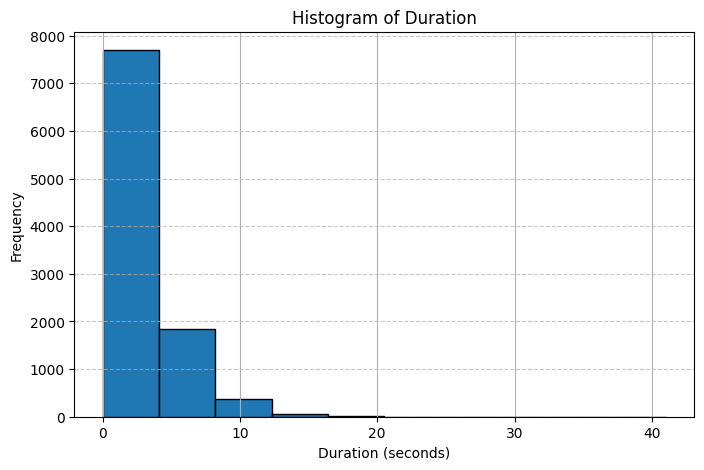

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
train_df['Duration'].hist(bins=10, edgecolor='black')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Duration')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x558d8c0a85c0] moov atom not found



Descriptive Statistics (frame_count):
       frame_count
count  9989.000000
mean     75.167484
std      58.243479
min       0.000000
25%      37.000000
50%      59.000000
75%      94.000000
max     984.000000


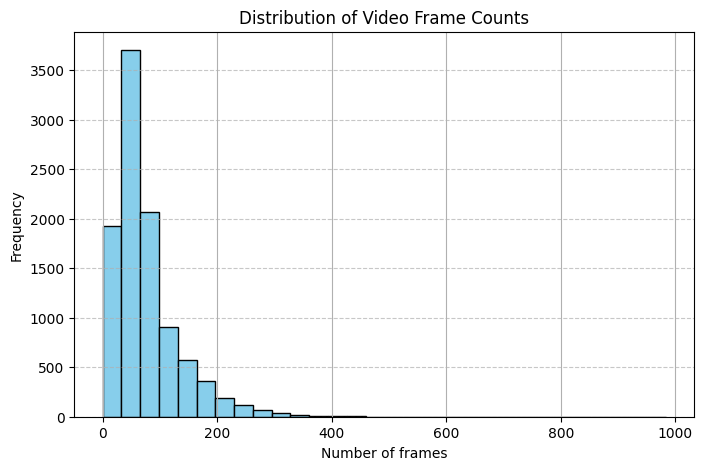

In [2]:
import os
import json
import cv2
import pandas as pd
import matplotlib.pyplot as plt

def show_video_frame_distribution(json_path):
    """
    Reads a JSON file containing video paths, computes frame counts,
    and shows descriptive stats plus a histogram.
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    frame_counts = []

    for item in data:
        video_path = item["video"]
        if not os.path.exists(video_path):
            print(f"Video file not found: {video_path}")
            continue        
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()

        frame_counts.append(total_frames)
    df = pd.DataFrame({"frame_count": frame_counts})
    print("\nDescriptive Statistics (frame_count):")
    print(df.describe())

    plt.figure(figsize=(8, 5))
    df["frame_count"].hist(bins=30, color="skyblue", edgecolor="black")
    plt.title("Distribution of Video Frame Counts")
    plt.xlabel("Number of frames")
    plt.ylabel("Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

train_data_json_path = os.path.join("..", "outputs", "preprocessed", "train_data.json")
show_video_frame_distribution(train_data_json_path)


**Representation of each label**

In [6]:
train_df['Emotion'].value_counts(ascending=True)

Emotion
fear         268
disgust      271
sadness      683
anger       1109
surprise    1205
joy         1743
neutral     4710
Name: count, dtype: int64

In [7]:
emotion_items = train_df['Emotion'].value_counts(ascending=True).index.tolist()
classes_to_fix = emotion_items[:3]
classes_to_fix

['fear', 'disgust', 'sadness']

In [ ]:
from utils.dataloader import create_data_loaders

train_data_json_path = os.path.join("..", "outputs", "preprocessed", "train_data.json")
dev_data_json_path = os.path.join("..", "outputs", "preprocessed", "dev_data.json")
test_data_json_path = os.path.join("..", "outputs", "preprocessed", "test_data.json")

dims = {"audio": 768, "text": 768, "video": 768}
train_loaders, val_loaders, label_mapping = create_data_loaders(train_data_json_path, dev_data_json_path, dims, batch_size=32, data_fraction=1, augmentation=True, augmentation_factor=0.5, classes_to_fix = classes_to_fix,
nber_cpu = 52)
test_loaders, _, _ = create_data_loaders(test_data_json_path, test_data_json_path, dims, batch_size=32, augmentation=False)

Number of samples in ../outputs/preprocessed/train_data.json: 9989
Number of samples after label reduction: 9989


licating 'fear':   0%|                              | 0/2087 [00:00<?, ?it/s]
                                                                             
licating 'sadness':   0%|                           | 0/1672 [00:00<?, ?it/s]
                                                                             
Replicating classes: 100%|███████████████████████| 7/7 [00:00<00:00, 316.39it/s]

Number of samples after augmentation: 15832



/home/conite.gbodogbe/anaconda3/envs/mer-gpu-2/lib/python3.9/site-packages/transformers/configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/home/conite.gbodogbe/anaconda3/envs/mer-gpu-2/lib/python3.9/site-packages/transformers/configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/home/conite.gbodogbe/anaconda3/envs/mer-gpu-2/lib/python3.9/site-packages/transformers/configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` t

Error processing audio: [Errno 2] No such file or directory: '../data/MELD.Raw/train/audio/dia125_utt3.wav'
Error: No valid frames extracted.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x2114b7c0] moov atom not found
/srv/lustre01/project/mml_bc-2q5huipcugq/users/conite.gbodogbe/Workspace/Multimodal_Emotion_Recognition/preprocessing/audio/preprocess_audio.py:53: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, _ = librosa.load(audio_path, sr=target_sample_rate)
/home/conite.gbodogbe/anaconda3/envs/mer-gpu-2/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing audio: 


Processing ../outputs/preprocessed/train_data.json:  36%|▎| 5713/15832 [1:27:04<

Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error proc

Processing ../outputs/preprocessed/train_data.json:  36%|▎| 5730/15832 [1:27:58<

Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error proc

Processing ../outputs/preprocessed/train_data.json:  36%|▎| 5755/15832 [1:28:19<

Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error proc

Processing ../outputs/preprocessed/train_data.json:  37%|▎| 5856/15832 [1:29:12<

Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'


Processing ../outputs/preprocessed/train_data.json:  37%|▎| 5874/15832 [1:29:14<

Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'


Processing ../outputs/preprocessed/train_data.json:  37%|▎| 5880/15832 [1:29:15<

Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error processing sample: preprocess_audio_for_model() got an unexpected keyword argument 'waveform_in_memory'
Error proc

In [1]:
print("Label Mapping:", label_mapping)

NameError: name 'label_mapping' is not defined

In [81]:

# total length of the dataset
print(len(train_loaders["audio"].dataset))
# total length of labels
print(len(train_loaders["audio"].dataset.tensors[1]))
train_loaders["audio"].dataset.tensors[1]


9988
9988


tensor([0, 0, 0,  ..., 6, 0, 1])

In [6]:
train_loaders, val_loaders, test_loaders

({'audio': <torch.utils.data.dataloader.DataLoader at 0x2adb70ad6d0>,
  'text': <torch.utils.data.dataloader.DataLoader at 0x2adb70ad790>,
  'video': <torch.utils.data.dataloader.DataLoader at 0x2adb70ad310>},
 {'audio': <torch.utils.data.dataloader.DataLoader at 0x2adb70ad190>,
  'text': <torch.utils.data.dataloader.DataLoader at 0x2adb6e92040>,
  'video': <torch.utils.data.dataloader.DataLoader at 0x2adb6793b20>},
 {'audio': <torch.utils.data.dataloader.DataLoader at 0x2adb67a5190>,
  'text': <torch.utils.data.dataloader.DataLoader at 0x2adb67a51c0>,
  'video': <torch.utils.data.dataloader.DataLoader at 0x2adb67a5070>})

**Saving dataset**

In [ ]:
# Save train, val, and test datasets
saving_dir = os.path.join("..", "outputs", "embeddings")
import torch

torch.save({
    'train': {
        'audio': train_loaders['audio'].dataset,
        'text': train_loaders['text'].dataset,
        'video': train_loaders['video'].dataset,
        'labels': train_loaders['audio'].dataset.tensors[1]
    },
    'val': {
        'audio': val_loaders['audio'].dataset,
        'text': val_loaders['text'].dataset,
        'video': val_loaders['video'].dataset,
        'labels': val_loaders['audio'].dataset.tensors[1]
    },
    'test': {
        'audio': test_loaders['audio'].dataset,
        'text': test_loaders['text'].dataset,
        'video': test_loaders['video'].dataset,
        'labels': test_loaders['audio'].dataset.tensors[1]
    }
}, os.path.join(saving_dir, "loaders_datasets.pt"))


**Loading**

In [2]:
import os
import torch
from torch.utils.data import DataLoader

saving_dir = os.path.join("..", "outputs", "embeddings")
saved_data = torch.load(os.path.join(saving_dir, "loaders_datasets.pt"))

train_loaders = {
    'audio': DataLoader(saved_data['train']['audio'], batch_size=32, shuffle=True),
    'text': DataLoader(saved_data['train']['text'], batch_size=32, shuffle=True),
    'video': DataLoader(saved_data['train']['video'], batch_size=32, shuffle=True),
    'label': DataLoader(saved_data['train']['labels'], batch_size=32, shuffle=True)
}

val_loaders = {
    'audio': DataLoader(saved_data['val']['audio'], batch_size=32, shuffle=False),
    'text': DataLoader(saved_data['val']['text'], batch_size=32, shuffle=False),
    'video': DataLoader(saved_data['val']['video'], batch_size=32, shuffle=False),
    'label': DataLoader(saved_data['val']['labels'], batch_size=32, shuffle=False)
}

test_loaders = {
    'audio': DataLoader(saved_data['test']['audio'], batch_size=32, shuffle=False),
    'text': DataLoader(saved_data['test']['text'], batch_size=32, shuffle=False),
    'video': DataLoader(saved_data['test']['video'], batch_size=32, shuffle=False),
    'label': DataLoader(saved_data['test']['labels'], batch_size=32, shuffle=False)
}


**3.0 Train and Validate**

**Audio**

In [ ]:

audio_model = AudioCNNClassifier(input_dim=768, num_classes=7)
train_model_audio = train_model(audio_model, train_loaders["audio"], val_loaders["audio"], num_epochs=500, learning_rate=1e-3, device="cpu", modal="audio", logfile=os.path.join("..", "logs", "training_logs", "audio_train.log"), verbose=False)


Epoch 1/500 - Training:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 500/500 - Training: 100%|██████████| 313/313 [00:03<00:00, 93.24it/s]


In [7]:
test_audio_loss, test_audio_acc, precision_audio, recall_audio, f1_audio = evaluate_model(train_model_audio, test_loaders["audio"], device="cpu", criterion=nn.CrossEntropyLoss(), modal="audio", logfile=os.path.join("..", "logs", "training_logs", "audio_test.log"))
print(f" Test Loss: {test_audio_loss}, Test Accuracy: {test_audio_acc}")
# Save the model
saving_dir = os.path.join("..", "outputs", "embeddings")
torch.save(train_model_audio.state_dict(), os.path.join('..', 'outputs', 'models',"audio_model.pt"))

Accuracy of class 0: 46.26%
Accuracy of class 1: 19.90%
Accuracy of class 2: 22.61%
Accuracy of class 3: 10.29%
Accuracy of class 4: 7.69%
Accuracy of class 5: 2.00%
Accuracy of class 6: 18.15%
Validation Metrics: Loss = 9.5960, Accuracy = 31.19%, Precision = 0.33, Recall = 0.31, F1 = 0.32
 Test Loss: 9.595992850094307, Test Accuracy: 31.18773946360153


In [8]:
from models.text.text_model import TextLSTMClassifier
                    
text_model = TextLSTMClassifier(input_dim=768, num_classes=7)

trained_text_model = train_model(
    text_model,
    train_loaders["text"],
    val_loaders["text"],
    num_epochs=500,
    learning_rate=1e-3,
    device="cpu",
    modal="text",
    logfile=os.path.join("..", "logs", "training_logs", "texte_train.log"),
    verbose=False
)


Epoch 500/500 - Training: 100%|██████████| 313/313 [00:01<00:00, 168.59it/s]


In [9]:

test_loss_text, test_accuracy_text, precision_text, recall_text, f1_text = evaluate_model(
    trained_text_model,
    test_loaders["text"],
    criterion=nn.CrossEntropyLoss(),
    device="cpu",
    modal="text",
    logfile=os.path.join("..", "logs", "training_logs", "text_test.log")
)

print(f"Text Test Loss: {test_loss_text:.4f}, Text Test Accuracy: {test_accuracy_text:.2f}% Text Precision: {precision_text:.2f}% Text Recall: {recall_text:.2f}% Text F1: {f1_text:.2f}%")
# Save the model
torch.save(trained_text_model.state_dict(), os.path.join('..', 'outputs', 'models',"text_model.pt"))

Accuracy of class 0: 77.71%
Accuracy of class 1: 58.46%
Accuracy of class 2: 33.33%
Accuracy of class 3: 11.76%
Accuracy of class 4: 14.42%
Accuracy of class 5: 2.00%
Accuracy of class 6: 53.74%
Validation Metrics: Loss = 3.9082, Accuracy = 58.08%, Precision = 0.56, Recall = 0.58, F1 = 0.56
Text Test Loss: 3.9082, Text Test Accuracy: 58.08% Text Precision: 0.56% Text Recall: 0.58% Text F1: 0.56%


**Video**

In [4]:
from models.video.video_model import VideoMLPClassifier

# Define the video model
video_model = VideoMLPClassifier(input_dim=768, num_classes=7)

# Train and validate the video model
trained_video_model = train_model(
    video_model,
    train_loaders["video"],
    val_loaders["video"],
    num_epochs=500,
    learning_rate=1e-3,
    device="cpu",
    modal="video",
    logfile=os.path.join("..", "logs", "training_logs", "video_train.log"),
    verbose=False
)

Epoch 1/500 - Training:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 500/500 - Training: 100%|██████████| 313/313 [00:01<00:00, 222.44it/s]


In [6]:

# Evaluate the video model on the test set
test_loss_video, test_accuracy_video, precision_video, recall_video, f1_video = evaluate_model(
    trained_video_model,
    test_loaders["video"],
    criterion=nn.CrossEntropyLoss(),
    device="cpu",
    modal="video",
    logfile=os.path.join("..", "logs", "training_logs", "video_test.log")
)
precision_video = precision_video * 100
recall_video = recall_video * 100
f1_video = f1_video * 100
print(f"Video Test Loss: {test_loss_video:.4f}, Video Test Accuracy: {test_accuracy_video:.2f}% Video Precision: {precision_video:.2f}% Video Recall: {recall_video:.2f}% Video F1: {f1_video:.2f}%")
# Save the model
torch.save(trained_video_model.state_dict(), os.path.join('..', 'outputs', 'models',"video_model.pt"))



Accuracy of class 0: 72.61%
Accuracy of class 1: 7.96%
Accuracy of class 2: 8.99%
Accuracy of class 3: 0.00%
Accuracy of class 4: 2.88%
Accuracy of class 5: 0.00%
Accuracy of class 6: 11.39%
Validation Metrics: Loss = 10.6023, Accuracy = 38.81%, Precision = 0.30, Recall = 0.39, F1 = 0.33
Video Test Loss: 10.6023, Video Test Accuracy: 38.81% Video Precision: 30.41% Video Recall: 38.81% Video F1: 33.11%


**Soft Voting**

In [7]:


import torch
import numpy as np

from models.bigru_coattention.multimodal import MultiModalDataset
saved_data = torch.load(os.path.join("..", "outputs", "embeddings", "loaders_datasets.pt"))


train_dataset = MultiModalDataset(
    saved_data['train']['audio'],
    saved_data['train']['text'],
    saved_data['train']['video'],
    saved_data['train']['labels']
)

val_dataset = MultiModalDataset(
    saved_data['val']['audio'],
    saved_data['val']['text'],
    saved_data['val']['video'],
    saved_data['val']['labels']
)

test_dataset = MultiModalDataset(
    saved_data['test']['audio'],
    saved_data['test']['text'],
    saved_data['test']['video'],
    saved_data['test']['labels']
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [38]:
# load the models
from models.audio.audio_model import AudioCNNClassifier
from models.text.text_model import TextLSTMClassifier
from models.video.video_model import VideoMLPClassifier

audio_model = AudioCNNClassifier(input_dim=768, num_classes=7)
audio_model.load_state_dict(torch.load(os.path.join('..', 'outputs', 'models',"audio_model.pt")))
audio_model.eval()

text_model = TextLSTMClassifier(input_dim=768, num_classes=7)
text_model.load_state_dict(torch.load(os.path.join('..', 'outputs', 'models',"text_model.pt")))
text_model.eval()

video_model = VideoMLPClassifier(input_dim=768, num_classes=7)
video_model.load_state_dict(torch.load(os.path.join('..', 'outputs', 'models',"video_model.pt")))
video_model.eval()



def majority_voting(audio_model, text_model, video_model, test_loader, device="cpu"):
    all_predictions = []
    all_labels = []

    audio_model.eval()
    text_model.eval()
    video_model.eval()

    with torch.no_grad():
        for batch in test_loader:
            audio_data, text_data, video_data, labels = batch

            # Move data to device
            audio_data = audio_data.to(device)
            text_data = text_data.to(device)
            video_data = video_data.to(device)
           
            audio_data = audio_data.unsqueeze(1)
            text_data = text_data.unsqueeze(1)




            audio_preds = audio_model(audio_data).argmax(dim=1).cpu().numpy()
            text_preds = text_model(text_data).argmax(dim=1).cpu().numpy()
            video_preds = video_model(video_data).argmax(dim=1).cpu().numpy()


            # Majority vote
            stacked_preds = np.stack([audio_preds, text_preds, video_preds], axis=0)
            final_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=stacked_preds)

            all_predictions.extend(final_preds)
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average="weighted")

    return accuracy, precision, recall, f1




accuracy, precision, recall, f1 = majority_voting(audio_model, text_model, video_model, test_loader)
print(f"Voting Accuracy: {accuracy * 100:.2f}%, Precision: {precision * 100:.2f}%, Recall: {recall * 100:.2f}%, F1: {f1 * 100:.2f}%")


Voting Accuracy: 50.46%, Precision: 42.54%, Recall: 50.46%, F1: 41.45%


## Anothers Approach

**2.1 BiGRU - Co-Attention Model**

In [ ]:
import os
import torch
from torch.utils.data import DataLoader
import sys, os
sys.path.append(os.path.abspath('..'))
from preprocessing.text.preprocess_text import preprocess_text_for_model, load_text_model
from preprocessing.audio.preprocess_audio import preprocess_audio_for_model, load_audio_model, extract_audio
from pipelines.preprocessing.data_pipeline import generate_metadata
import numpy as np
import torch.nn as nn
from pipelines.training.training_pipeline import train_model, train_model_coattention
from models.audio.audio_model import AudioCNNClassifier
from pipelines.training.training_pipeline import evaluate_model

from torch import nn, optim
from tqdm import tqdm
from models.bigru_coattention.coattention import CoAttentionFusion
from utils.logger import create_logger
from sklearn.metrics import precision_score, recall_score, f1_score
from pipelines.evaluation.evaluation_pipeline import test_model_coattention, evaluate_model_coattention
from models.bigru_coattention.multimodal import MultiModalDataset





import torch
import numpy as np

saved_data = torch.load(os.path.join("..", "outputs", "embeddings", "loaders_datasets.pt"))


train_dataset = MultiModalDataset(
    saved_data['train']['audio'],
    saved_data['train']['text'],
    saved_data['train']['video'],
    saved_data['train']['labels']
)

val_dataset = MultiModalDataset(
    saved_data['val']['audio'],
    saved_data['val']['text'],
    saved_data['val']['video'],
    saved_data['val']['labels']
)

test_dataset = MultiModalDataset(
    saved_data['test']['audio'],
    saved_data['test']['text'],
    saved_data['test']['video'],
    saved_data['test']['labels']
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --------------------------------------------------------------------------------
# Train Model
# --------------------------------------------------------------------------------

co_attention_model = CoAttentionFusion(input_dim_audio=768, input_dim_text=768, input_dim_video=768, num_classes=7 )
trained_model_coattention = train_model_coattention(co_attention_model, train_loader, val_loader, num_epochs=500, learning_rate=1e-3, device="cpu", logfile=os.path.join("..", "logs", "training_logs", "coattention_train.log"), verbose=False)
#  save the model



Epoch 1/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.61it/s]


Epoch 1: Train Loss = 1.3868, Val Loss = 1.3472, Val Accuracy = 54.96%, Precision = 0.45, Recall = 0.55, F1 = 0.49


Epoch 2/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.18it/s]


Epoch 2: Train Loss = 1.3026, Val Loss = 1.3746, Val Accuracy = 53.25%, Precision = 0.45, Recall = 0.53, F1 = 0.47


Epoch 3/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.16it/s]


Epoch 3: Train Loss = 1.2404, Val Loss = 1.4019, Val Accuracy = 54.51%, Precision = 0.46, Recall = 0.55, F1 = 0.47


Epoch 4/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.48it/s]


Epoch 4: Train Loss = 1.2028, Val Loss = 1.2804, Val Accuracy = 55.60%, Precision = 0.45, Recall = 0.56, F1 = 0.47


Epoch 5/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.36it/s]


Epoch 5: Train Loss = 1.1788, Val Loss = 1.3121, Val Accuracy = 57.94%, Precision = 0.48, Recall = 0.58, F1 = 0.51


Epoch 6/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.77it/s]


Epoch 6: Train Loss = 1.1692, Val Loss = 1.3436, Val Accuracy = 55.69%, Precision = 0.47, Recall = 0.56, F1 = 0.49


Epoch 7/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.65it/s]


Epoch 7: Train Loss = 1.1546, Val Loss = 1.3093, Val Accuracy = 55.60%, Precision = 0.47, Recall = 0.56, F1 = 0.47


Epoch 8/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.75it/s]


Epoch 8: Train Loss = 1.1460, Val Loss = 1.2986, Val Accuracy = 55.87%, Precision = 0.46, Recall = 0.56, F1 = 0.51


Epoch 9/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.49it/s]


Epoch 9: Train Loss = 1.1252, Val Loss = 1.2709, Val Accuracy = 58.48%, Precision = 0.53, Recall = 0.58, F1 = 0.54


Epoch 10/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.62it/s]


Epoch 10: Train Loss = 1.1211, Val Loss = 1.3478, Val Accuracy = 57.04%, Precision = 0.47, Recall = 0.57, F1 = 0.50


Epoch 11/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.06it/s]


Epoch 11: Train Loss = 1.1096, Val Loss = 1.3186, Val Accuracy = 55.87%, Precision = 0.49, Recall = 0.56, F1 = 0.49


Epoch 12/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.92it/s]


Epoch 12: Train Loss = 1.0937, Val Loss = 1.2693, Val Accuracy = 58.84%, Precision = 0.55, Recall = 0.59, F1 = 0.54


Epoch 13/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.32it/s]


Epoch 13: Train Loss = 1.1098, Val Loss = 1.2985, Val Accuracy = 56.86%, Precision = 0.52, Recall = 0.57, F1 = 0.52


Epoch 14/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.42it/s]


Epoch 14: Train Loss = 1.0741, Val Loss = 1.3609, Val Accuracy = 56.68%, Precision = 0.51, Recall = 0.57, F1 = 0.51


Epoch 15/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.23it/s]


Epoch 15: Train Loss = 1.0680, Val Loss = 1.2782, Val Accuracy = 58.94%, Precision = 0.54, Recall = 0.59, F1 = 0.55


Epoch 16/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.28it/s]


Epoch 16: Train Loss = 1.0812, Val Loss = 1.3105, Val Accuracy = 57.40%, Precision = 0.53, Recall = 0.57, F1 = 0.53


Epoch 17/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.70it/s]


Epoch 17: Train Loss = 1.0506, Val Loss = 1.3094, Val Accuracy = 58.03%, Precision = 0.53, Recall = 0.58, F1 = 0.54


Epoch 18/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.29it/s]


Epoch 18: Train Loss = 1.0464, Val Loss = 1.3700, Val Accuracy = 55.69%, Precision = 0.51, Recall = 0.56, F1 = 0.52


Epoch 19/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.39it/s]


Epoch 19: Train Loss = 1.0668, Val Loss = 1.4247, Val Accuracy = 57.04%, Precision = 0.54, Recall = 0.57, F1 = 0.51


Epoch 20/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.24it/s]


Epoch 20: Train Loss = 1.0404, Val Loss = 1.3024, Val Accuracy = 57.58%, Precision = 0.52, Recall = 0.58, F1 = 0.52


Epoch 21/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.20it/s]


Epoch 21: Train Loss = 1.0300, Val Loss = 1.2766, Val Accuracy = 58.30%, Precision = 0.48, Recall = 0.58, F1 = 0.52


Epoch 22/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.39it/s]


Epoch 22: Train Loss = 1.0142, Val Loss = 1.3648, Val Accuracy = 55.96%, Precision = 0.53, Recall = 0.56, F1 = 0.53


Epoch 23/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.53it/s]


Epoch 23: Train Loss = 1.0140, Val Loss = 1.3195, Val Accuracy = 57.40%, Precision = 0.53, Recall = 0.57, F1 = 0.54


Epoch 24/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.79it/s]


Epoch 24: Train Loss = 0.9965, Val Loss = 1.3260, Val Accuracy = 56.86%, Precision = 0.52, Recall = 0.57, F1 = 0.52


Epoch 25/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.64it/s]


Epoch 25: Train Loss = 0.9846, Val Loss = 1.3427, Val Accuracy = 57.49%, Precision = 0.50, Recall = 0.57, F1 = 0.52


Epoch 26/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.64it/s]


Epoch 26: Train Loss = 0.9701, Val Loss = 1.3664, Val Accuracy = 58.03%, Precision = 0.53, Recall = 0.58, F1 = 0.54


Epoch 27/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.56it/s]


Epoch 27: Train Loss = 0.9438, Val Loss = 1.4937, Val Accuracy = 57.04%, Precision = 0.51, Recall = 0.57, F1 = 0.53


Epoch 28/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.29it/s]


Epoch 28: Train Loss = 0.9384, Val Loss = 1.3529, Val Accuracy = 56.95%, Precision = 0.51, Recall = 0.57, F1 = 0.51


Epoch 29/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.50it/s]


Epoch 29: Train Loss = 0.9201, Val Loss = 1.3569, Val Accuracy = 57.49%, Precision = 0.52, Recall = 0.57, F1 = 0.53


Epoch 30/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.18it/s]


Epoch 30: Train Loss = 1.0265, Val Loss = 1.3938, Val Accuracy = 56.59%, Precision = 0.52, Recall = 0.57, F1 = 0.54


Epoch 31/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.03it/s]


Epoch 31: Train Loss = 0.9133, Val Loss = 1.3777, Val Accuracy = 56.59%, Precision = 0.51, Recall = 0.57, F1 = 0.52


Epoch 32/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.55it/s]


Epoch 32: Train Loss = 0.8896, Val Loss = 1.5708, Val Accuracy = 58.48%, Precision = 0.52, Recall = 0.58, F1 = 0.54


Epoch 33/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.34it/s]


Epoch 33: Train Loss = 0.8670, Val Loss = 1.5687, Val Accuracy = 56.50%, Precision = 0.52, Recall = 0.56, F1 = 0.54


Epoch 34/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.11it/s]


Epoch 34: Train Loss = 0.8519, Val Loss = 1.4807, Val Accuracy = 57.94%, Precision = 0.53, Recall = 0.58, F1 = 0.54


Epoch 35/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.01it/s]


Epoch 35: Train Loss = 0.8347, Val Loss = 1.5557, Val Accuracy = 58.21%, Precision = 0.52, Recall = 0.58, F1 = 0.54


Epoch 36/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.11it/s]


Epoch 36: Train Loss = 0.8233, Val Loss = 1.6182, Val Accuracy = 55.78%, Precision = 0.52, Recall = 0.56, F1 = 0.53


Epoch 37/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


Epoch 37: Train Loss = 0.8174, Val Loss = 1.6141, Val Accuracy = 56.95%, Precision = 0.52, Recall = 0.57, F1 = 0.53


Epoch 38/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.28it/s]


Epoch 38: Train Loss = 0.8221, Val Loss = 1.6331, Val Accuracy = 56.23%, Precision = 0.50, Recall = 0.56, F1 = 0.53


Epoch 39/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.14it/s]


Epoch 39: Train Loss = 0.7894, Val Loss = 1.6021, Val Accuracy = 57.31%, Precision = 0.52, Recall = 0.57, F1 = 0.54


Epoch 40/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.36it/s]


Epoch 40: Train Loss = 0.8097, Val Loss = 1.5463, Val Accuracy = 58.30%, Precision = 0.53, Recall = 0.58, F1 = 0.54


Epoch 41/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.66it/s]


Epoch 41: Train Loss = 0.7807, Val Loss = 1.6934, Val Accuracy = 56.68%, Precision = 0.50, Recall = 0.57, F1 = 0.52


Epoch 42/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.65it/s]


Epoch 42: Train Loss = 0.7540, Val Loss = 1.5963, Val Accuracy = 56.86%, Precision = 0.51, Recall = 0.57, F1 = 0.53


Epoch 43/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.83it/s]


Epoch 43: Train Loss = 0.9623, Val Loss = 1.5473, Val Accuracy = 56.50%, Precision = 0.50, Recall = 0.56, F1 = 0.52


Epoch 44/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.86it/s]


Epoch 44: Train Loss = 0.8728, Val Loss = 1.4268, Val Accuracy = 57.49%, Precision = 0.52, Recall = 0.57, F1 = 0.54


Epoch 45/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.13it/s]


Epoch 45: Train Loss = 0.8195, Val Loss = 1.4841, Val Accuracy = 56.68%, Precision = 0.51, Recall = 0.57, F1 = 0.53


Epoch 46/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.96it/s]


Epoch 46: Train Loss = 0.7635, Val Loss = 1.5720, Val Accuracy = 56.77%, Precision = 0.52, Recall = 0.57, F1 = 0.54


Epoch 47/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.05it/s]


Epoch 47: Train Loss = 0.8017, Val Loss = 1.5824, Val Accuracy = 56.41%, Precision = 0.52, Recall = 0.56, F1 = 0.53


Epoch 48/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.00it/s]


Epoch 48: Train Loss = 0.7700, Val Loss = 1.4954, Val Accuracy = 47.83%, Precision = 0.43, Recall = 0.48, F1 = 0.41


Epoch 49/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.06it/s]


Epoch 49: Train Loss = 1.0466, Val Loss = 1.3952, Val Accuracy = 56.68%, Precision = 0.51, Recall = 0.57, F1 = 0.53


Epoch 50/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.53it/s]


Epoch 50: Train Loss = 1.0051, Val Loss = 1.3645, Val Accuracy = 56.50%, Precision = 0.52, Recall = 0.56, F1 = 0.54


Epoch 51/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.83it/s]


Epoch 51: Train Loss = 0.9227, Val Loss = 1.3965, Val Accuracy = 56.23%, Precision = 0.52, Recall = 0.56, F1 = 0.54


Epoch 52/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.74it/s]


Epoch 52: Train Loss = 0.8898, Val Loss = 1.4344, Val Accuracy = 55.51%, Precision = 0.51, Recall = 0.56, F1 = 0.53


Epoch 53/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.75it/s]


Epoch 53: Train Loss = 0.8366, Val Loss = 1.5165, Val Accuracy = 55.05%, Precision = 0.49, Recall = 0.55, F1 = 0.51


Epoch 54/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.27it/s]


Epoch 54: Train Loss = 0.8124, Val Loss = 1.5437, Val Accuracy = 56.77%, Precision = 0.52, Recall = 0.57, F1 = 0.53


Epoch 55/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.44it/s]


Epoch 55: Train Loss = 0.7702, Val Loss = 1.6264, Val Accuracy = 56.41%, Precision = 0.54, Recall = 0.56, F1 = 0.53


Epoch 56/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.66it/s]


Epoch 56: Train Loss = 0.7595, Val Loss = 1.6975, Val Accuracy = 56.32%, Precision = 0.52, Recall = 0.56, F1 = 0.54


Epoch 57/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.67it/s]


Epoch 57: Train Loss = 0.7451, Val Loss = 1.7968, Val Accuracy = 57.04%, Precision = 0.55, Recall = 0.57, F1 = 0.53


Epoch 58/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.90it/s]


Epoch 58: Train Loss = 0.8091, Val Loss = 1.5775, Val Accuracy = 57.04%, Precision = 0.51, Recall = 0.57, F1 = 0.53


Epoch 59/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.77it/s]


Epoch 59: Train Loss = 0.9079, Val Loss = 1.5103, Val Accuracy = 55.14%, Precision = 0.50, Recall = 0.55, F1 = 0.51


Epoch 60/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.66it/s]


Epoch 60: Train Loss = 0.8013, Val Loss = 1.5654, Val Accuracy = 54.69%, Precision = 0.50, Recall = 0.55, F1 = 0.52


Epoch 61/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.05it/s]


Epoch 61: Train Loss = 0.7554, Val Loss = 1.5882, Val Accuracy = 56.14%, Precision = 0.51, Recall = 0.56, F1 = 0.53


Epoch 62/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.62it/s]


Epoch 62: Train Loss = 0.6834, Val Loss = 1.8172, Val Accuracy = 54.69%, Precision = 0.51, Recall = 0.55, F1 = 0.51


Epoch 63/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.40it/s]


Epoch 63: Train Loss = 0.6475, Val Loss = 1.7666, Val Accuracy = 54.24%, Precision = 0.50, Recall = 0.54, F1 = 0.51


Epoch 64/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.71it/s]


Epoch 64: Train Loss = 0.6154, Val Loss = 1.9485, Val Accuracy = 54.15%, Precision = 0.50, Recall = 0.54, F1 = 0.51


Epoch 65/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.81it/s]


Epoch 65: Train Loss = 0.6251, Val Loss = 1.9477, Val Accuracy = 55.23%, Precision = 0.49, Recall = 0.55, F1 = 0.51


Epoch 66/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.90it/s]


Epoch 66: Train Loss = 0.6798, Val Loss = 2.0710, Val Accuracy = 55.32%, Precision = 0.52, Recall = 0.55, F1 = 0.54


Epoch 67/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.99it/s]


Epoch 67: Train Loss = 0.6412, Val Loss = 1.6822, Val Accuracy = 55.32%, Precision = 0.51, Recall = 0.55, F1 = 0.52


Epoch 68/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.83it/s]


Epoch 68: Train Loss = 0.6651, Val Loss = 1.7074, Val Accuracy = 55.42%, Precision = 0.50, Recall = 0.55, F1 = 0.51


Epoch 69/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.69it/s]


Epoch 69: Train Loss = 0.5933, Val Loss = 2.3150, Val Accuracy = 53.88%, Precision = 0.50, Recall = 0.54, F1 = 0.52


Epoch 70/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.87it/s]


Epoch 70: Train Loss = 0.5471, Val Loss = 2.1291, Val Accuracy = 52.44%, Precision = 0.49, Recall = 0.52, F1 = 0.50


Epoch 71/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.65it/s]


Epoch 71: Train Loss = 0.5485, Val Loss = 2.3592, Val Accuracy = 53.52%, Precision = 0.50, Recall = 0.54, F1 = 0.51


Epoch 72/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.88it/s]


Epoch 72: Train Loss = 0.6703, Val Loss = 1.7926, Val Accuracy = 54.87%, Precision = 0.52, Recall = 0.55, F1 = 0.52


Epoch 73/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.98it/s]


Epoch 73: Train Loss = 0.5469, Val Loss = 2.3786, Val Accuracy = 53.88%, Precision = 0.51, Recall = 0.54, F1 = 0.52


Epoch 74/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.78it/s]


Epoch 74: Train Loss = 0.4989, Val Loss = 2.5393, Val Accuracy = 50.18%, Precision = 0.48, Recall = 0.50, F1 = 0.49


Epoch 75/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.15it/s]


Epoch 75: Train Loss = 0.4993, Val Loss = 2.1802, Val Accuracy = 51.99%, Precision = 0.49, Recall = 0.52, F1 = 0.49


Epoch 76/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.50it/s]


Epoch 76: Train Loss = 0.4931, Val Loss = 2.1538, Val Accuracy = 54.15%, Precision = 0.50, Recall = 0.54, F1 = 0.52


Epoch 77/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.46it/s]


Epoch 77: Train Loss = 0.7275, Val Loss = 1.7354, Val Accuracy = 55.42%, Precision = 0.51, Recall = 0.55, F1 = 0.52


Epoch 78/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.54it/s]


Epoch 78: Train Loss = 0.6766, Val Loss = 1.9722, Val Accuracy = 53.79%, Precision = 0.50, Recall = 0.54, F1 = 0.50


Epoch 79/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.40it/s]


Epoch 79: Train Loss = 0.5797, Val Loss = 1.9386, Val Accuracy = 53.61%, Precision = 0.50, Recall = 0.54, F1 = 0.51


Epoch 80/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.45it/s]


Epoch 80: Train Loss = 0.4781, Val Loss = 2.5062, Val Accuracy = 52.17%, Precision = 0.48, Recall = 0.52, F1 = 0.50


Epoch 81/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.58it/s]


Epoch 81: Train Loss = 0.4470, Val Loss = 2.5667, Val Accuracy = 52.62%, Precision = 0.50, Recall = 0.53, F1 = 0.51


Epoch 82/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.59it/s]


Epoch 82: Train Loss = 0.3929, Val Loss = 2.7112, Val Accuracy = 52.80%, Precision = 0.51, Recall = 0.53, F1 = 0.51


Epoch 83/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.54it/s]


Epoch 83: Train Loss = 0.3675, Val Loss = 2.7859, Val Accuracy = 50.63%, Precision = 0.48, Recall = 0.51, F1 = 0.49


Epoch 84/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.60it/s]


Epoch 84: Train Loss = 0.3702, Val Loss = 2.8160, Val Accuracy = 51.08%, Precision = 0.48, Recall = 0.51, F1 = 0.49


Epoch 85/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.99it/s]


Epoch 85: Train Loss = 0.4269, Val Loss = 2.5675, Val Accuracy = 52.98%, Precision = 0.49, Recall = 0.53, F1 = 0.50


Epoch 86/500 - Training: 100%|██████████| 313/313 [00:17<00:00, 17.46it/s]


Epoch 86: Train Loss = 0.3869, Val Loss = 2.7107, Val Accuracy = 50.63%, Precision = 0.48, Recall = 0.51, F1 = 0.49


Epoch 87/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.14it/s]


Epoch 87: Train Loss = 0.3642, Val Loss = 3.0235, Val Accuracy = 50.36%, Precision = 0.48, Recall = 0.50, F1 = 0.49


Epoch 88/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.08it/s]


Epoch 88: Train Loss = 0.3334, Val Loss = 3.0393, Val Accuracy = 52.17%, Precision = 0.49, Recall = 0.52, F1 = 0.50


Epoch 89/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.07it/s]


Epoch 89: Train Loss = 0.3090, Val Loss = 3.3234, Val Accuracy = 48.83%, Precision = 0.47, Recall = 0.49, F1 = 0.47


Epoch 90/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.07it/s]


Epoch 90: Train Loss = 0.3354, Val Loss = 2.9711, Val Accuracy = 49.91%, Precision = 0.48, Recall = 0.50, F1 = 0.49


Epoch 91/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.98it/s]


Epoch 91: Train Loss = 0.3344, Val Loss = 2.7717, Val Accuracy = 51.81%, Precision = 0.49, Recall = 0.52, F1 = 0.49


Epoch 92/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.25it/s]


Epoch 92: Train Loss = 0.3489, Val Loss = 2.9677, Val Accuracy = 52.53%, Precision = 0.49, Recall = 0.53, F1 = 0.50


Epoch 93/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.16it/s]


Epoch 93: Train Loss = 0.2892, Val Loss = 3.2852, Val Accuracy = 52.62%, Precision = 0.50, Recall = 0.53, F1 = 0.51


Epoch 94/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.31it/s]


Epoch 94: Train Loss = 0.3027, Val Loss = 3.0658, Val Accuracy = 51.44%, Precision = 0.49, Recall = 0.51, F1 = 0.50


Epoch 95/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.95it/s]


Epoch 95: Train Loss = 0.2824, Val Loss = 3.3582, Val Accuracy = 50.09%, Precision = 0.47, Recall = 0.50, F1 = 0.48


Epoch 96/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.21it/s]


Epoch 96: Train Loss = 0.3761, Val Loss = 2.8480, Val Accuracy = 50.27%, Precision = 0.46, Recall = 0.50, F1 = 0.47


Epoch 97/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.06it/s]


Epoch 97: Train Loss = 0.3223, Val Loss = 3.0713, Val Accuracy = 49.64%, Precision = 0.47, Recall = 0.50, F1 = 0.48


Epoch 98/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.05it/s]


Epoch 98: Train Loss = 0.3050, Val Loss = 3.4514, Val Accuracy = 50.63%, Precision = 0.47, Recall = 0.51, F1 = 0.48


Epoch 99/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.11it/s]


Epoch 99: Train Loss = 0.2769, Val Loss = 3.0109, Val Accuracy = 51.17%, Precision = 0.50, Recall = 0.51, F1 = 0.50


Epoch 100/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.24it/s]


Epoch 100: Train Loss = 0.2517, Val Loss = 3.6010, Val Accuracy = 51.08%, Precision = 0.48, Recall = 0.51, F1 = 0.49


Epoch 101/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.94it/s]


Epoch 101: Train Loss = 0.2420, Val Loss = 3.2732, Val Accuracy = 51.71%, Precision = 0.48, Recall = 0.52, F1 = 0.49


Epoch 102/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.02it/s]


Epoch 102: Train Loss = 0.2684, Val Loss = 3.1462, Val Accuracy = 50.99%, Precision = 0.48, Recall = 0.51, F1 = 0.49


Epoch 103/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.21it/s]


Epoch 103: Train Loss = 0.2734, Val Loss = 3.5293, Val Accuracy = 53.79%, Precision = 0.50, Recall = 0.54, F1 = 0.51


Epoch 104/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.03it/s]


Epoch 104: Train Loss = 0.2486, Val Loss = 3.3434, Val Accuracy = 51.08%, Precision = 0.48, Recall = 0.51, F1 = 0.49


Epoch 105/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.30it/s]


Epoch 105: Train Loss = 0.2281, Val Loss = 3.5384, Val Accuracy = 51.08%, Precision = 0.48, Recall = 0.51, F1 = 0.49


Epoch 106/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.09it/s]


Epoch 106: Train Loss = 0.2170, Val Loss = 3.2829, Val Accuracy = 49.46%, Precision = 0.48, Recall = 0.49, F1 = 0.49


Epoch 107/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.82it/s]


Epoch 107: Train Loss = 0.2334, Val Loss = 3.6731, Val Accuracy = 52.44%, Precision = 0.49, Recall = 0.52, F1 = 0.50


Epoch 108/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.23it/s]


Epoch 108: Train Loss = 0.2140, Val Loss = 3.7497, Val Accuracy = 50.27%, Precision = 0.46, Recall = 0.50, F1 = 0.48


Epoch 109/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.14it/s]


Epoch 109: Train Loss = 0.2306, Val Loss = 3.1811, Val Accuracy = 51.44%, Precision = 0.49, Recall = 0.51, F1 = 0.50


Epoch 110/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.24it/s]


Epoch 110: Train Loss = 0.2229, Val Loss = 3.4630, Val Accuracy = 49.46%, Precision = 0.47, Recall = 0.49, F1 = 0.48


Epoch 111/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.31it/s]


Epoch 111: Train Loss = 0.2150, Val Loss = 3.2565, Val Accuracy = 50.45%, Precision = 0.48, Recall = 0.50, F1 = 0.49


Epoch 112/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.19it/s]


Epoch 112: Train Loss = 0.2058, Val Loss = 3.4535, Val Accuracy = 50.27%, Precision = 0.47, Recall = 0.50, F1 = 0.48


Epoch 113/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.40it/s]


Epoch 113: Train Loss = 0.2234, Val Loss = 3.1600, Val Accuracy = 51.53%, Precision = 0.51, Recall = 0.52, F1 = 0.51


Epoch 114/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.37it/s]


Epoch 114: Train Loss = 0.1986, Val Loss = 3.8652, Val Accuracy = 51.17%, Precision = 0.48, Recall = 0.51, F1 = 0.49


Epoch 115/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.20it/s]


Epoch 115: Train Loss = 0.3034, Val Loss = 3.3406, Val Accuracy = 52.08%, Precision = 0.49, Recall = 0.52, F1 = 0.50


Epoch 116/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.34it/s]


Epoch 116: Train Loss = 0.2192, Val Loss = 3.3041, Val Accuracy = 51.17%, Precision = 0.49, Recall = 0.51, F1 = 0.50


Epoch 117/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


Epoch 117: Train Loss = 0.2614, Val Loss = 3.2146, Val Accuracy = 48.74%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 118/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.26it/s]


Epoch 118: Train Loss = 0.3206, Val Loss = 3.3915, Val Accuracy = 50.72%, Precision = 0.48, Recall = 0.51, F1 = 0.48


Epoch 119/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.21it/s]


Epoch 119: Train Loss = 0.2632, Val Loss = 2.8532, Val Accuracy = 42.15%, Precision = 0.44, Recall = 0.42, F1 = 0.42


Epoch 120/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


Epoch 120: Train Loss = 0.7152, Val Loss = 2.2284, Val Accuracy = 50.09%, Precision = 0.47, Recall = 0.50, F1 = 0.48


Epoch 121/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.31it/s]


Epoch 121: Train Loss = 0.5801, Val Loss = 2.2393, Val Accuracy = 51.90%, Precision = 0.48, Recall = 0.52, F1 = 0.49


Epoch 122/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s]


Epoch 122: Train Loss = 0.4495, Val Loss = 2.5574, Val Accuracy = 52.26%, Precision = 0.48, Recall = 0.52, F1 = 0.49


Epoch 123/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.26it/s]


Epoch 123: Train Loss = 0.3892, Val Loss = 2.0940, Val Accuracy = 53.88%, Precision = 0.49, Recall = 0.54, F1 = 0.50


Epoch 124/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.98it/s]


Epoch 124: Train Loss = 0.4149, Val Loss = 2.6244, Val Accuracy = 49.64%, Precision = 0.46, Recall = 0.50, F1 = 0.47


Epoch 125/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.37it/s]


Epoch 125: Train Loss = 0.3974, Val Loss = 2.4200, Val Accuracy = 50.36%, Precision = 0.46, Recall = 0.50, F1 = 0.48


Epoch 126/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.77it/s]


Epoch 126: Train Loss = 0.7615, Val Loss = 1.5648, Val Accuracy = 56.59%, Precision = 0.53, Recall = 0.57, F1 = 0.53


Epoch 127/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.86it/s]


Epoch 127: Train Loss = 0.7279, Val Loss = 1.8908, Val Accuracy = 54.06%, Precision = 0.51, Recall = 0.54, F1 = 0.52


Epoch 128/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.77it/s]


Epoch 128: Train Loss = 0.5888, Val Loss = 2.2099, Val Accuracy = 52.26%, Precision = 0.48, Recall = 0.52, F1 = 0.49


Epoch 129/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.37it/s]


Epoch 129: Train Loss = 0.5911, Val Loss = 1.8659, Val Accuracy = 52.44%, Precision = 0.48, Recall = 0.52, F1 = 0.49


Epoch 130/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.58it/s]


Epoch 130: Train Loss = 0.6408, Val Loss = 1.7039, Val Accuracy = 49.64%, Precision = 0.42, Recall = 0.50, F1 = 0.43


Epoch 131/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s]


Epoch 131: Train Loss = 0.6960, Val Loss = 2.0243, Val Accuracy = 50.90%, Precision = 0.46, Recall = 0.51, F1 = 0.48


Epoch 132/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.39it/s]


Epoch 132: Train Loss = 0.5392, Val Loss = 2.1453, Val Accuracy = 49.82%, Precision = 0.46, Recall = 0.50, F1 = 0.48


Epoch 133/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.48it/s]


Epoch 133: Train Loss = 0.4598, Val Loss = 2.5643, Val Accuracy = 52.62%, Precision = 0.48, Recall = 0.53, F1 = 0.49


Epoch 134/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.40it/s]


Epoch 134: Train Loss = 0.3760, Val Loss = 2.8028, Val Accuracy = 51.53%, Precision = 0.46, Recall = 0.52, F1 = 0.47


Epoch 135/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s]


Epoch 135: Train Loss = 0.3124, Val Loss = 3.1985, Val Accuracy = 49.64%, Precision = 0.45, Recall = 0.50, F1 = 0.46


Epoch 136/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.27it/s]


Epoch 136: Train Loss = 0.3196, Val Loss = 3.1284, Val Accuracy = 49.55%, Precision = 0.47, Recall = 0.50, F1 = 0.47


Epoch 137/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.35it/s]


Epoch 137: Train Loss = 0.2582, Val Loss = 3.1844, Val Accuracy = 49.55%, Precision = 0.47, Recall = 0.50, F1 = 0.48


Epoch 138/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.94it/s]


Epoch 138: Train Loss = 0.2544, Val Loss = 3.2775, Val Accuracy = 52.62%, Precision = 0.49, Recall = 0.53, F1 = 0.50


Epoch 139/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.28it/s]


Epoch 139: Train Loss = 0.2235, Val Loss = 3.1511, Val Accuracy = 51.90%, Precision = 0.47, Recall = 0.52, F1 = 0.49


Epoch 140/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.29it/s]


Epoch 140: Train Loss = 0.2289, Val Loss = 3.5858, Val Accuracy = 50.27%, Precision = 0.46, Recall = 0.50, F1 = 0.47


Epoch 141/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.30it/s]


Epoch 141: Train Loss = 0.2134, Val Loss = 3.4520, Val Accuracy = 50.45%, Precision = 0.46, Recall = 0.50, F1 = 0.48


Epoch 142/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.38it/s]


Epoch 142: Train Loss = 0.2878, Val Loss = 2.8298, Val Accuracy = 48.47%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 143/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.36it/s]


Epoch 143: Train Loss = 0.5664, Val Loss = 1.9507, Val Accuracy = 50.09%, Precision = 0.44, Recall = 0.50, F1 = 0.46


Epoch 144/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.35it/s]


Epoch 144: Train Loss = 0.4923, Val Loss = 2.5367, Val Accuracy = 48.29%, Precision = 0.44, Recall = 0.48, F1 = 0.46


Epoch 145/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.27it/s]


Epoch 145: Train Loss = 0.3693, Val Loss = 2.7891, Val Accuracy = 48.83%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 146/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.12it/s]


Epoch 146: Train Loss = 0.3018, Val Loss = 3.1616, Val Accuracy = 49.10%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 147/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.08it/s]


Epoch 147: Train Loss = 0.2596, Val Loss = 3.4986, Val Accuracy = 48.47%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 148/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.32it/s]


Epoch 148: Train Loss = 0.2853, Val Loss = 2.3230, Val Accuracy = 52.08%, Precision = 0.49, Recall = 0.52, F1 = 0.50


Epoch 149/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.34it/s]


Epoch 149: Train Loss = 0.4262, Val Loss = 1.9997, Val Accuracy = 49.46%, Precision = 0.44, Recall = 0.49, F1 = 0.46


Epoch 150/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


Epoch 150: Train Loss = 0.6530, Val Loss = 2.2152, Val Accuracy = 50.18%, Precision = 0.46, Recall = 0.50, F1 = 0.47


Epoch 151/500 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.52it/s]


Epoch 151: Train Loss = 0.5341, Val Loss = 2.0814, Val Accuracy = 53.88%, Precision = 0.48, Recall = 0.54, F1 = 0.49


Epoch 152/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.22it/s]


Epoch 152: Train Loss = 0.4639, Val Loss = 2.4737, Val Accuracy = 51.17%, Precision = 0.47, Recall = 0.51, F1 = 0.48


Epoch 153/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.01it/s]


Epoch 153: Train Loss = 0.3404, Val Loss = 2.7604, Val Accuracy = 47.92%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 154/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.15it/s]


Epoch 154: Train Loss = 0.3588, Val Loss = 2.7190, Val Accuracy = 48.47%, Precision = 0.46, Recall = 0.48, F1 = 0.47


Epoch 155/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.70it/s]


Epoch 155: Train Loss = 0.2868, Val Loss = 2.8862, Val Accuracy = 50.36%, Precision = 0.47, Recall = 0.50, F1 = 0.48


Epoch 156/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.22it/s]


Epoch 156: Train Loss = 0.2653, Val Loss = 3.2107, Val Accuracy = 50.27%, Precision = 0.44, Recall = 0.50, F1 = 0.46


Epoch 157/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.27it/s]


Epoch 157: Train Loss = 0.2375, Val Loss = 2.9940, Val Accuracy = 50.45%, Precision = 0.48, Recall = 0.50, F1 = 0.49


Epoch 158/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.20it/s]


Epoch 158: Train Loss = 0.2463, Val Loss = 3.1919, Val Accuracy = 49.73%, Precision = 0.46, Recall = 0.50, F1 = 0.47


Epoch 159/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.11it/s]


Epoch 159: Train Loss = 0.2271, Val Loss = 3.3356, Val Accuracy = 49.01%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 160/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.20it/s]


Epoch 160: Train Loss = 0.2001, Val Loss = 3.4815, Val Accuracy = 50.90%, Precision = 0.48, Recall = 0.51, F1 = 0.48


Epoch 161/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.58it/s]


Epoch 161: Train Loss = 0.1921, Val Loss = 3.7273, Val Accuracy = 47.74%, Precision = 0.44, Recall = 0.48, F1 = 0.46


Epoch 162/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.29it/s]


Epoch 162: Train Loss = 0.3439, Val Loss = 3.1220, Val Accuracy = 49.46%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 163/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.36it/s]


Epoch 163: Train Loss = 0.2122, Val Loss = 3.4203, Val Accuracy = 47.65%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 164/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.12it/s]


Epoch 164: Train Loss = 0.1817, Val Loss = 3.7280, Val Accuracy = 48.83%, Precision = 0.44, Recall = 0.49, F1 = 0.46


Epoch 165/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.08it/s]


Epoch 165: Train Loss = 0.1585, Val Loss = 4.1033, Val Accuracy = 47.83%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 166/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.31it/s]


Epoch 166: Train Loss = 0.1691, Val Loss = 3.6705, Val Accuracy = 48.74%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 167/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.41it/s]


Epoch 167: Train Loss = 0.2259, Val Loss = 2.7787, Val Accuracy = 50.00%, Precision = 0.46, Recall = 0.50, F1 = 0.47


Epoch 168/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.99it/s]


Epoch 168: Train Loss = 0.3965, Val Loss = 2.1252, Val Accuracy = 51.53%, Precision = 0.48, Recall = 0.52, F1 = 0.49


Epoch 169/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.14it/s]


Epoch 169: Train Loss = 0.3728, Val Loss = 2.9333, Val Accuracy = 48.56%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 170/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.14it/s]


Epoch 170: Train Loss = 0.2093, Val Loss = 3.8284, Val Accuracy = 48.92%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 171/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.11it/s]


Epoch 171: Train Loss = 0.3257, Val Loss = 2.2896, Val Accuracy = 49.10%, Precision = 0.43, Recall = 0.49, F1 = 0.45


Epoch 172/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.28it/s]


Epoch 172: Train Loss = 0.5415, Val Loss = 2.7565, Val Accuracy = 50.54%, Precision = 0.46, Recall = 0.51, F1 = 0.47


Epoch 173/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.20it/s]


Epoch 173: Train Loss = 0.3714, Val Loss = 2.6324, Val Accuracy = 50.00%, Precision = 0.46, Recall = 0.50, F1 = 0.47


Epoch 174/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.13it/s]


Epoch 174: Train Loss = 0.3753, Val Loss = 3.0785, Val Accuracy = 48.83%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 175/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.24it/s]


Epoch 175: Train Loss = 0.2703, Val Loss = 3.4801, Val Accuracy = 50.45%, Precision = 0.46, Recall = 0.50, F1 = 0.47


Epoch 176/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.21it/s]


Epoch 176: Train Loss = 0.1887, Val Loss = 3.4300, Val Accuracy = 46.93%, Precision = 0.47, Recall = 0.47, F1 = 0.46


Epoch 177/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.14it/s]


Epoch 177: Train Loss = 0.2215, Val Loss = 3.6995, Val Accuracy = 51.17%, Precision = 0.47, Recall = 0.51, F1 = 0.48


Epoch 178/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.00it/s]


Epoch 178: Train Loss = 0.1817, Val Loss = 3.7866, Val Accuracy = 51.08%, Precision = 0.48, Recall = 0.51, F1 = 0.49


Epoch 179/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.22it/s]


Epoch 179: Train Loss = 0.1959, Val Loss = 2.8480, Val Accuracy = 50.81%, Precision = 0.47, Recall = 0.51, F1 = 0.48


Epoch 180/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.13it/s]


Epoch 180: Train Loss = 0.2085, Val Loss = 3.7648, Val Accuracy = 50.18%, Precision = 0.49, Recall = 0.50, F1 = 0.49


Epoch 181/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.18it/s]


Epoch 181: Train Loss = 0.1943, Val Loss = 3.5269, Val Accuracy = 48.10%, Precision = 0.46, Recall = 0.48, F1 = 0.47


Epoch 182/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.09it/s]


Epoch 182: Train Loss = 0.1816, Val Loss = 3.9201, Val Accuracy = 48.74%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 183/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.86it/s]


Epoch 183: Train Loss = 0.1571, Val Loss = 3.4133, Val Accuracy = 50.72%, Precision = 0.47, Recall = 0.51, F1 = 0.48


Epoch 184/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.11it/s]


Epoch 184: Train Loss = 0.3580, Val Loss = 2.7013, Val Accuracy = 49.64%, Precision = 0.46, Recall = 0.50, F1 = 0.47


Epoch 185/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.02it/s]


Epoch 185: Train Loss = 0.2680, Val Loss = 3.3846, Val Accuracy = 50.99%, Precision = 0.47, Recall = 0.51, F1 = 0.48


Epoch 186/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.00it/s]


Epoch 186: Train Loss = 0.1684, Val Loss = 3.4863, Val Accuracy = 48.56%, Precision = 0.46, Recall = 0.49, F1 = 0.46


Epoch 187/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.07it/s]


Epoch 187: Train Loss = 0.1412, Val Loss = 4.0770, Val Accuracy = 50.36%, Precision = 0.46, Recall = 0.50, F1 = 0.48


Epoch 188/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.14it/s]


Epoch 188: Train Loss = 0.1243, Val Loss = 3.4347, Val Accuracy = 50.90%, Precision = 0.47, Recall = 0.51, F1 = 0.49


Epoch 189/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.94it/s]


Epoch 189: Train Loss = 0.1710, Val Loss = 3.9755, Val Accuracy = 49.01%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 190/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.04it/s]


Epoch 190: Train Loss = 0.1558, Val Loss = 4.2255, Val Accuracy = 48.01%, Precision = 0.46, Recall = 0.48, F1 = 0.46


Epoch 191/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.97it/s]


Epoch 191: Train Loss = 0.1343, Val Loss = 4.0003, Val Accuracy = 49.10%, Precision = 0.47, Recall = 0.49, F1 = 0.47


Epoch 192/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.97it/s]


Epoch 192: Train Loss = 0.1503, Val Loss = 4.0849, Val Accuracy = 49.91%, Precision = 0.46, Recall = 0.50, F1 = 0.47


Epoch 193/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.07it/s]


Epoch 193: Train Loss = 0.1380, Val Loss = 4.0482, Val Accuracy = 49.46%, Precision = 0.47, Recall = 0.49, F1 = 0.48


Epoch 194/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.02it/s]


Epoch 194: Train Loss = 0.1205, Val Loss = 4.5122, Val Accuracy = 50.18%, Precision = 0.49, Recall = 0.50, F1 = 0.49


Epoch 195/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.97it/s]


Epoch 195: Train Loss = 0.1573, Val Loss = 3.9234, Val Accuracy = 49.19%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 196/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.91it/s]


Epoch 196: Train Loss = 0.1239, Val Loss = 4.2900, Val Accuracy = 49.19%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 197/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.05it/s]


Epoch 197: Train Loss = 0.1026, Val Loss = 4.5535, Val Accuracy = 50.81%, Precision = 0.48, Recall = 0.51, F1 = 0.48


Epoch 198/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.91it/s]


Epoch 198: Train Loss = 0.1048, Val Loss = 4.2939, Val Accuracy = 48.83%, Precision = 0.48, Recall = 0.49, F1 = 0.48


Epoch 199/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.17it/s]


Epoch 199: Train Loss = 0.3737, Val Loss = 2.9488, Val Accuracy = 48.47%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 200/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.18it/s]


Epoch 200: Train Loss = 0.2268, Val Loss = 3.8818, Val Accuracy = 45.13%, Precision = 0.44, Recall = 0.45, F1 = 0.45


Epoch 201/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.03it/s]


Epoch 201: Train Loss = 0.1833, Val Loss = 4.2916, Val Accuracy = 46.84%, Precision = 0.45, Recall = 0.47, F1 = 0.46


Epoch 202/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.66it/s]


Epoch 202: Train Loss = 0.1343, Val Loss = 4.7198, Val Accuracy = 44.49%, Precision = 0.42, Recall = 0.44, F1 = 0.43


Epoch 203/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.11it/s]


Epoch 203: Train Loss = 0.1585, Val Loss = 4.1085, Val Accuracy = 48.10%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 204/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.98it/s]


Epoch 204: Train Loss = 0.1472, Val Loss = 4.5094, Val Accuracy = 48.74%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 205/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.98it/s]


Epoch 205: Train Loss = 0.1540, Val Loss = 4.3232, Val Accuracy = 48.65%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 206/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.01it/s]


Epoch 206: Train Loss = 0.1341, Val Loss = 4.2651, Val Accuracy = 50.36%, Precision = 0.47, Recall = 0.50, F1 = 0.48


Epoch 207/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.99it/s]


Epoch 207: Train Loss = 0.1145, Val Loss = 4.5384, Val Accuracy = 50.90%, Precision = 0.47, Recall = 0.51, F1 = 0.48


Epoch 208/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.16it/s]


Epoch 208: Train Loss = 0.1180, Val Loss = 4.5695, Val Accuracy = 48.19%, Precision = 0.46, Recall = 0.48, F1 = 0.46


Epoch 209/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.30it/s]


Epoch 209: Train Loss = 0.2012, Val Loss = 3.4309, Val Accuracy = 49.73%, Precision = 0.46, Recall = 0.50, F1 = 0.47


Epoch 210/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.28it/s]


Epoch 210: Train Loss = 0.1655, Val Loss = 4.1516, Val Accuracy = 47.47%, Precision = 0.46, Recall = 0.47, F1 = 0.46


Epoch 211/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.07it/s]


Epoch 211: Train Loss = 0.1029, Val Loss = 4.6801, Val Accuracy = 49.37%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 212/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.15it/s]


Epoch 212: Train Loss = 0.0978, Val Loss = 4.4411, Val Accuracy = 49.82%, Precision = 0.46, Recall = 0.50, F1 = 0.47


Epoch 213/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.04it/s]


Epoch 213: Train Loss = 0.1158, Val Loss = 4.6417, Val Accuracy = 49.28%, Precision = 0.45, Recall = 0.49, F1 = 0.47


Epoch 214/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.69it/s]


Epoch 214: Train Loss = 0.1259, Val Loss = 4.0339, Val Accuracy = 49.10%, Precision = 0.47, Recall = 0.49, F1 = 0.47


Epoch 215/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.89it/s]


Epoch 215: Train Loss = 0.1218, Val Loss = 4.6821, Val Accuracy = 48.65%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 216/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.82it/s]


Epoch 216: Train Loss = 0.1108, Val Loss = 4.2602, Val Accuracy = 49.10%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 217/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.00it/s]


Epoch 217: Train Loss = 0.0913, Val Loss = 4.9099, Val Accuracy = 49.91%, Precision = 0.47, Recall = 0.50, F1 = 0.47


Epoch 218/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.01it/s]


Epoch 218: Train Loss = 0.1199, Val Loss = 4.3117, Val Accuracy = 46.93%, Precision = 0.46, Recall = 0.47, F1 = 0.45


Epoch 219/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.00it/s]


Epoch 219: Train Loss = 0.1343, Val Loss = 4.0760, Val Accuracy = 49.37%, Precision = 0.47, Recall = 0.49, F1 = 0.47


Epoch 220/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.87it/s]


Epoch 220: Train Loss = 0.0983, Val Loss = 4.3956, Val Accuracy = 47.47%, Precision = 0.46, Recall = 0.47, F1 = 0.47


Epoch 221/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.86it/s]


Epoch 221: Train Loss = 0.1067, Val Loss = 4.6366, Val Accuracy = 47.11%, Precision = 0.45, Recall = 0.47, F1 = 0.45


Epoch 222/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.74it/s]


Epoch 222: Train Loss = 0.1187, Val Loss = 4.4543, Val Accuracy = 48.47%, Precision = 0.43, Recall = 0.48, F1 = 0.45


Epoch 223/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.84it/s]


Epoch 223: Train Loss = 0.2027, Val Loss = 4.0104, Val Accuracy = 49.28%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 224/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.95it/s]


Epoch 224: Train Loss = 0.1146, Val Loss = 4.5288, Val Accuracy = 48.47%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 225/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.77it/s]


Epoch 225: Train Loss = 0.1703, Val Loss = 4.5145, Val Accuracy = 47.74%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 226/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.93it/s]


Epoch 226: Train Loss = 0.1003, Val Loss = 4.6805, Val Accuracy = 50.45%, Precision = 0.46, Recall = 0.50, F1 = 0.47


Epoch 227/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.75it/s]


Epoch 227: Train Loss = 0.0793, Val Loss = 4.9883, Val Accuracy = 49.37%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 228/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.71it/s]


Epoch 228: Train Loss = 0.0954, Val Loss = 5.0031, Val Accuracy = 46.57%, Precision = 0.43, Recall = 0.47, F1 = 0.44


Epoch 229/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.57it/s]


Epoch 229: Train Loss = 0.0882, Val Loss = 5.0281, Val Accuracy = 49.46%, Precision = 0.47, Recall = 0.49, F1 = 0.47


Epoch 230/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.76it/s]


Epoch 230: Train Loss = 0.1063, Val Loss = 4.8748, Val Accuracy = 50.36%, Precision = 0.47, Recall = 0.50, F1 = 0.48


Epoch 231/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.92it/s]


Epoch 231: Train Loss = 0.1543, Val Loss = 4.5660, Val Accuracy = 49.10%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 232/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.83it/s]


Epoch 232: Train Loss = 0.1174, Val Loss = 4.1035, Val Accuracy = 50.27%, Precision = 0.46, Recall = 0.50, F1 = 0.47


Epoch 233/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.96it/s]


Epoch 233: Train Loss = 0.1096, Val Loss = 4.4245, Val Accuracy = 51.99%, Precision = 0.48, Recall = 0.52, F1 = 0.49


Epoch 234/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.76it/s]


Epoch 234: Train Loss = 0.0881, Val Loss = 5.0528, Val Accuracy = 47.20%, Precision = 0.45, Recall = 0.47, F1 = 0.45


Epoch 235/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.58it/s]


Epoch 235: Train Loss = 0.0960, Val Loss = 4.7992, Val Accuracy = 47.74%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 236/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.81it/s]


Epoch 236: Train Loss = 0.1122, Val Loss = 4.7828, Val Accuracy = 48.10%, Precision = 0.44, Recall = 0.48, F1 = 0.46


Epoch 237/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.88it/s]


Epoch 237: Train Loss = 0.0915, Val Loss = 4.3847, Val Accuracy = 46.30%, Precision = 0.45, Recall = 0.46, F1 = 0.45


Epoch 238/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.81it/s]


Epoch 238: Train Loss = 0.0943, Val Loss = 5.0250, Val Accuracy = 46.84%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 239/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.80it/s]


Epoch 239: Train Loss = 0.1587, Val Loss = 3.4076, Val Accuracy = 48.56%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 240/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.82it/s]


Epoch 240: Train Loss = 0.2148, Val Loss = 3.9923, Val Accuracy = 46.03%, Precision = 0.44, Recall = 0.46, F1 = 0.45


Epoch 241/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.75it/s]


Epoch 241: Train Loss = 0.1199, Val Loss = 4.5182, Val Accuracy = 48.29%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 242/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.86it/s]


Epoch 242: Train Loss = 0.0884, Val Loss = 5.2336, Val Accuracy = 50.09%, Precision = 0.46, Recall = 0.50, F1 = 0.47


Epoch 243/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.90it/s]


Epoch 243: Train Loss = 0.1156, Val Loss = 4.2355, Val Accuracy = 48.38%, Precision = 0.44, Recall = 0.48, F1 = 0.46


Epoch 244/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.89it/s]


Epoch 244: Train Loss = 0.0927, Val Loss = 4.7556, Val Accuracy = 48.10%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 245/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.92it/s]


Epoch 245: Train Loss = 0.0961, Val Loss = 4.5946, Val Accuracy = 46.93%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 246/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.75it/s]


Epoch 246: Train Loss = 0.1074, Val Loss = 5.0910, Val Accuracy = 46.39%, Precision = 0.43, Recall = 0.46, F1 = 0.44


Epoch 247/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.94it/s]


Epoch 247: Train Loss = 0.1203, Val Loss = 4.6251, Val Accuracy = 47.20%, Precision = 0.45, Recall = 0.47, F1 = 0.45


Epoch 248/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.76it/s]


Epoch 248: Train Loss = 0.0790, Val Loss = 5.3560, Val Accuracy = 49.82%, Precision = 0.46, Recall = 0.50, F1 = 0.47


Epoch 249/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.74it/s]


Epoch 249: Train Loss = 0.0714, Val Loss = 5.1461, Val Accuracy = 47.02%, Precision = 0.45, Recall = 0.47, F1 = 0.45


Epoch 250/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.66it/s]


Epoch 250: Train Loss = 0.1542, Val Loss = 4.3140, Val Accuracy = 48.47%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 251/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.07it/s]


Epoch 251: Train Loss = 0.1091, Val Loss = 4.6223, Val Accuracy = 48.38%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 252/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.87it/s]


Epoch 252: Train Loss = 0.0901, Val Loss = 4.6460, Val Accuracy = 49.01%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 253/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.88it/s]


Epoch 253: Train Loss = 0.0731, Val Loss = 5.0663, Val Accuracy = 46.39%, Precision = 0.44, Recall = 0.46, F1 = 0.45


Epoch 254/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.09it/s]


Epoch 254: Train Loss = 0.1015, Val Loss = 4.2636, Val Accuracy = 47.65%, Precision = 0.46, Recall = 0.48, F1 = 0.46


Epoch 255/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.96it/s]


Epoch 255: Train Loss = 0.1099, Val Loss = 4.1367, Val Accuracy = 48.38%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 256/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.06it/s]


Epoch 256: Train Loss = 0.1111, Val Loss = 4.4695, Val Accuracy = 48.83%, Precision = 0.47, Recall = 0.49, F1 = 0.47


Epoch 257/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.01it/s]


Epoch 257: Train Loss = 0.0911, Val Loss = 4.9300, Val Accuracy = 48.47%, Precision = 0.46, Recall = 0.48, F1 = 0.47


Epoch 258/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.75it/s]


Epoch 258: Train Loss = 0.0758, Val Loss = 5.0700, Val Accuracy = 48.83%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 259/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.31it/s]


Epoch 259: Train Loss = 0.0826, Val Loss = 4.5318, Val Accuracy = 50.63%, Precision = 0.49, Recall = 0.51, F1 = 0.49


Epoch 260/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.82it/s]


Epoch 260: Train Loss = 0.0732, Val Loss = 4.7736, Val Accuracy = 48.74%, Precision = 0.47, Recall = 0.49, F1 = 0.47


Epoch 261/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.64it/s]


Epoch 261: Train Loss = 0.0768, Val Loss = 5.1374, Val Accuracy = 47.38%, Precision = 0.45, Recall = 0.47, F1 = 0.45


Epoch 262/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.68it/s]


Epoch 262: Train Loss = 0.1607, Val Loss = 2.0899, Val Accuracy = 47.56%, Precision = 0.43, Recall = 0.48, F1 = 0.44


Epoch 263/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.74it/s]


Epoch 263: Train Loss = 0.2998, Val Loss = 3.5667, Val Accuracy = 49.01%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 264/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.86it/s]


Epoch 264: Train Loss = 0.1150, Val Loss = 4.2765, Val Accuracy = 45.22%, Precision = 0.44, Recall = 0.45, F1 = 0.44


Epoch 265/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.66it/s]


Epoch 265: Train Loss = 0.0858, Val Loss = 4.9758, Val Accuracy = 49.19%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 266/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.78it/s]


Epoch 266: Train Loss = 0.1011, Val Loss = 4.6940, Val Accuracy = 48.29%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 267/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.67it/s]


Epoch 267: Train Loss = 0.0791, Val Loss = 5.1480, Val Accuracy = 48.56%, Precision = 0.46, Recall = 0.49, F1 = 0.46


Epoch 268/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.73it/s]


Epoch 268: Train Loss = 0.0956, Val Loss = 4.4906, Val Accuracy = 49.28%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 269/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.67it/s]


Epoch 269: Train Loss = 0.0797, Val Loss = 4.8905, Val Accuracy = 49.64%, Precision = 0.46, Recall = 0.50, F1 = 0.46


Epoch 270/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.83it/s]


Epoch 270: Train Loss = 0.0718, Val Loss = 5.2350, Val Accuracy = 50.36%, Precision = 0.46, Recall = 0.50, F1 = 0.47


Epoch 271/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.84it/s]


Epoch 271: Train Loss = 0.0828, Val Loss = 5.0254, Val Accuracy = 46.12%, Precision = 0.45, Recall = 0.46, F1 = 0.45


Epoch 272/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.94it/s]


Epoch 272: Train Loss = 0.0671, Val Loss = 5.0528, Val Accuracy = 49.37%, Precision = 0.47, Recall = 0.49, F1 = 0.47


Epoch 273/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.94it/s]


Epoch 273: Train Loss = 0.1657, Val Loss = 4.0408, Val Accuracy = 49.19%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 274/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.89it/s]


Epoch 274: Train Loss = 0.0879, Val Loss = 4.9653, Val Accuracy = 49.28%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 275/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.62it/s]


Epoch 275: Train Loss = 0.0990, Val Loss = 4.1784, Val Accuracy = 49.01%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 276/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.92it/s]


Epoch 276: Train Loss = 0.0860, Val Loss = 5.1383, Val Accuracy = 48.01%, Precision = 0.46, Recall = 0.48, F1 = 0.46


Epoch 277/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.81it/s]


Epoch 277: Train Loss = 0.0715, Val Loss = 4.8712, Val Accuracy = 48.65%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 278/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.11it/s]


Epoch 278: Train Loss = 0.0893, Val Loss = 4.8016, Val Accuracy = 48.65%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 279/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.06it/s]


Epoch 279: Train Loss = 0.0769, Val Loss = 5.1692, Val Accuracy = 48.92%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 280/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.92it/s]


Epoch 280: Train Loss = 0.0800, Val Loss = 4.9000, Val Accuracy = 47.74%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 281/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.94it/s]


Epoch 281: Train Loss = 0.0640, Val Loss = 5.4419, Val Accuracy = 47.83%, Precision = 0.46, Recall = 0.48, F1 = 0.46


Epoch 282/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.89it/s]


Epoch 282: Train Loss = 0.0975, Val Loss = 4.9065, Val Accuracy = 47.29%, Precision = 0.45, Recall = 0.47, F1 = 0.46


Epoch 283/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.04it/s]


Epoch 283: Train Loss = 0.0808, Val Loss = 5.0534, Val Accuracy = 49.01%, Precision = 0.45, Recall = 0.49, F1 = 0.45


Epoch 284/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.93it/s]


Epoch 284: Train Loss = 0.0946, Val Loss = 4.6908, Val Accuracy = 49.01%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 285/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.01it/s]


Epoch 285: Train Loss = 0.0894, Val Loss = 5.2318, Val Accuracy = 49.46%, Precision = 0.46, Recall = 0.49, F1 = 0.46


Epoch 286/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.84it/s]


Epoch 286: Train Loss = 0.1579, Val Loss = 3.7875, Val Accuracy = 48.29%, Precision = 0.44, Recall = 0.48, F1 = 0.46


Epoch 287/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.28it/s]


Epoch 287: Train Loss = 0.1338, Val Loss = 4.3348, Val Accuracy = 44.13%, Precision = 0.44, Recall = 0.44, F1 = 0.44


Epoch 288/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.77it/s]


Epoch 288: Train Loss = 0.1010, Val Loss = 4.4807, Val Accuracy = 49.01%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 289/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.24it/s]


Epoch 289: Train Loss = 0.3559, Val Loss = 2.9526, Val Accuracy = 48.01%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 290/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.14it/s]


Epoch 290: Train Loss = 0.2110, Val Loss = 3.8283, Val Accuracy = 48.29%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 291/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.05it/s]


Epoch 291: Train Loss = 0.0951, Val Loss = 5.1737, Val Accuracy = 48.19%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 292/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.97it/s]


Epoch 292: Train Loss = 0.0679, Val Loss = 5.2224, Val Accuracy = 47.65%, Precision = 0.43, Recall = 0.48, F1 = 0.45


Epoch 293/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.93it/s]


Epoch 293: Train Loss = 0.0957, Val Loss = 5.1397, Val Accuracy = 48.74%, Precision = 0.44, Recall = 0.49, F1 = 0.45


Epoch 294/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.81it/s]


Epoch 294: Train Loss = 0.0617, Val Loss = 5.6489, Val Accuracy = 46.39%, Precision = 0.44, Recall = 0.46, F1 = 0.45


Epoch 295/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.99it/s]


Epoch 295: Train Loss = 0.0664, Val Loss = 5.6040, Val Accuracy = 45.67%, Precision = 0.42, Recall = 0.46, F1 = 0.43


Epoch 296/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.99it/s]


Epoch 296: Train Loss = 0.0857, Val Loss = 5.2801, Val Accuracy = 46.66%, Precision = 0.43, Recall = 0.47, F1 = 0.44


Epoch 297/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.06it/s]


Epoch 297: Train Loss = 0.0736, Val Loss = 5.0615, Val Accuracy = 46.21%, Precision = 0.43, Recall = 0.46, F1 = 0.44


Epoch 298/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.96it/s]


Epoch 298: Train Loss = 0.0898, Val Loss = 5.2276, Val Accuracy = 48.29%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 299/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.84it/s]


Epoch 299: Train Loss = 0.0706, Val Loss = 5.6917, Val Accuracy = 48.01%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 300/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.85it/s]


Epoch 300: Train Loss = 0.0770, Val Loss = 5.1230, Val Accuracy = 49.37%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 301/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.73it/s]


Epoch 301: Train Loss = 0.0737, Val Loss = 5.5120, Val Accuracy = 48.83%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 302/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.06it/s]


Epoch 302: Train Loss = 0.1537, Val Loss = 4.7899, Val Accuracy = 46.48%, Precision = 0.45, Recall = 0.46, F1 = 0.45


Epoch 303/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.64it/s]


Epoch 303: Train Loss = 0.0826, Val Loss = 5.1510, Val Accuracy = 47.20%, Precision = 0.45, Recall = 0.47, F1 = 0.45


Epoch 304/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.98it/s]


Epoch 304: Train Loss = 0.0895, Val Loss = 5.3096, Val Accuracy = 45.67%, Precision = 0.43, Recall = 0.46, F1 = 0.43


Epoch 305/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.85it/s]


Epoch 305: Train Loss = 0.0691, Val Loss = 5.5521, Val Accuracy = 47.29%, Precision = 0.45, Recall = 0.47, F1 = 0.46


Epoch 306/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.77it/s]


Epoch 306: Train Loss = 0.0868, Val Loss = 5.4828, Val Accuracy = 48.19%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 307/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.62it/s]


Epoch 307: Train Loss = 0.1275, Val Loss = 4.3747, Val Accuracy = 46.66%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 308/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.83it/s]


Epoch 308: Train Loss = 0.1089, Val Loss = 5.0755, Val Accuracy = 46.21%, Precision = 0.43, Recall = 0.46, F1 = 0.44


Epoch 309/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.88it/s]


Epoch 309: Train Loss = 0.0849, Val Loss = 5.3198, Val Accuracy = 49.46%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 310/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.72it/s]


Epoch 310: Train Loss = 0.0817, Val Loss = 5.5308, Val Accuracy = 48.29%, Precision = 0.45, Recall = 0.48, F1 = 0.45


Epoch 311/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.85it/s]


Epoch 311: Train Loss = 0.0786, Val Loss = 4.1806, Val Accuracy = 48.65%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 312/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.86it/s]


Epoch 312: Train Loss = 0.0817, Val Loss = 5.0995, Val Accuracy = 49.73%, Precision = 0.46, Recall = 0.50, F1 = 0.47


Epoch 313/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.74it/s]


Epoch 313: Train Loss = 0.0598, Val Loss = 5.2464, Val Accuracy = 46.84%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 314/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.32it/s]


Epoch 314: Train Loss = 0.0778, Val Loss = 5.4502, Val Accuracy = 46.57%, Precision = 0.43, Recall = 0.47, F1 = 0.44


Epoch 315/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 14.92it/s]


Epoch 315: Train Loss = 0.1046, Val Loss = 5.2056, Val Accuracy = 49.55%, Precision = 0.46, Recall = 0.50, F1 = 0.46


Epoch 316/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.59it/s]


Epoch 316: Train Loss = 0.1118, Val Loss = 4.7572, Val Accuracy = 47.20%, Precision = 0.45, Recall = 0.47, F1 = 0.45


Epoch 317/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.45it/s]


Epoch 317: Train Loss = 0.0950, Val Loss = 4.9622, Val Accuracy = 46.21%, Precision = 0.42, Recall = 0.46, F1 = 0.43


Epoch 318/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.42it/s]


Epoch 318: Train Loss = 0.1248, Val Loss = 4.5730, Val Accuracy = 48.47%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 319/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.46it/s]


Epoch 319: Train Loss = 0.0852, Val Loss = 5.2117, Val Accuracy = 47.56%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 320/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.42it/s]


Epoch 320: Train Loss = 0.1076, Val Loss = 5.0422, Val Accuracy = 48.19%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 321/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.35it/s]


Epoch 321: Train Loss = 0.0907, Val Loss = 5.0171, Val Accuracy = 47.29%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 322/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.45it/s]


Epoch 322: Train Loss = 0.0880, Val Loss = 5.2339, Val Accuracy = 47.38%, Precision = 0.43, Recall = 0.47, F1 = 0.45


Epoch 323/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.80it/s]


Epoch 323: Train Loss = 0.2724, Val Loss = 4.1168, Val Accuracy = 47.83%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 324/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.55it/s]


Epoch 324: Train Loss = 0.1132, Val Loss = 4.8506, Val Accuracy = 48.56%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 325/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.43it/s]


Epoch 325: Train Loss = 0.0643, Val Loss = 5.2838, Val Accuracy = 49.37%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 326/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.55it/s]


Epoch 326: Train Loss = 0.0900, Val Loss = 5.2215, Val Accuracy = 49.19%, Precision = 0.44, Recall = 0.49, F1 = 0.46


Epoch 327/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.47it/s]


Epoch 327: Train Loss = 0.0648, Val Loss = 5.4846, Val Accuracy = 46.84%, Precision = 0.42, Recall = 0.47, F1 = 0.43


Epoch 328/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.46it/s]


Epoch 328: Train Loss = 0.0535, Val Loss = 5.9791, Val Accuracy = 48.56%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 329/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.51it/s]


Epoch 329: Train Loss = 0.0768, Val Loss = 5.1630, Val Accuracy = 47.65%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 330/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.43it/s]


Epoch 330: Train Loss = 0.1222, Val Loss = 4.9561, Val Accuracy = 48.83%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 331/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.51it/s]


Epoch 331: Train Loss = 0.0740, Val Loss = 5.2726, Val Accuracy = 49.19%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 332/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.67it/s]


Epoch 332: Train Loss = 0.1130, Val Loss = 5.0442, Val Accuracy = 46.84%, Precision = 0.43, Recall = 0.47, F1 = 0.45


Epoch 333/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.09it/s]


Epoch 333: Train Loss = 0.0692, Val Loss = 5.1684, Val Accuracy = 46.57%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 334/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.11it/s]


Epoch 334: Train Loss = 0.0553, Val Loss = 5.7822, Val Accuracy = 44.95%, Precision = 0.42, Recall = 0.45, F1 = 0.43


Epoch 335/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.05it/s]


Epoch 335: Train Loss = 0.0665, Val Loss = 5.5820, Val Accuracy = 48.10%, Precision = 0.45, Recall = 0.48, F1 = 0.45


Epoch 336/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.22it/s]


Epoch 336: Train Loss = 0.0937, Val Loss = 5.0662, Val Accuracy = 48.92%, Precision = 0.44, Recall = 0.49, F1 = 0.45


Epoch 337/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.16it/s]


Epoch 337: Train Loss = 0.1036, Val Loss = 4.9183, Val Accuracy = 49.46%, Precision = 0.46, Recall = 0.49, F1 = 0.46


Epoch 338/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.23it/s]


Epoch 338: Train Loss = 0.0718, Val Loss = 5.4272, Val Accuracy = 49.37%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 339/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.24it/s]


Epoch 339: Train Loss = 0.1179, Val Loss = 4.9745, Val Accuracy = 47.74%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 340/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.06it/s]


Epoch 340: Train Loss = 0.0794, Val Loss = 5.1226, Val Accuracy = 48.83%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 341/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.16it/s]


Epoch 341: Train Loss = 0.1464, Val Loss = 4.3750, Val Accuracy = 48.83%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 342/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.26it/s]


Epoch 342: Train Loss = 0.1018, Val Loss = 4.4125, Val Accuracy = 49.64%, Precision = 0.46, Recall = 0.50, F1 = 0.47


Epoch 343/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.19it/s]


Epoch 343: Train Loss = 0.0944, Val Loss = 5.1646, Val Accuracy = 49.01%, Precision = 0.46, Recall = 0.49, F1 = 0.46


Epoch 344/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.08it/s]


Epoch 344: Train Loss = 0.0664, Val Loss = 5.3803, Val Accuracy = 49.19%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 345/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.32it/s]


Epoch 345: Train Loss = 0.1652, Val Loss = 4.4600, Val Accuracy = 47.38%, Precision = 0.45, Recall = 0.47, F1 = 0.45


Epoch 346/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.19it/s]


Epoch 346: Train Loss = 0.1108, Val Loss = 4.5240, Val Accuracy = 46.48%, Precision = 0.44, Recall = 0.46, F1 = 0.45


Epoch 347/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.82it/s]


Epoch 347: Train Loss = 0.0917, Val Loss = 4.9883, Val Accuracy = 46.66%, Precision = 0.43, Recall = 0.47, F1 = 0.44


Epoch 348/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.14it/s]


Epoch 348: Train Loss = 0.0706, Val Loss = 5.3640, Val Accuracy = 46.21%, Precision = 0.44, Recall = 0.46, F1 = 0.45


Epoch 349/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.90it/s]


Epoch 349: Train Loss = 0.0566, Val Loss = 5.7034, Val Accuracy = 46.66%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 350/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.92it/s]


Epoch 350: Train Loss = 0.0517, Val Loss = 5.6120, Val Accuracy = 48.38%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 351/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.06it/s]


Epoch 351: Train Loss = 0.0865, Val Loss = 5.3568, Val Accuracy = 46.84%, Precision = 0.45, Recall = 0.47, F1 = 0.45


Epoch 352/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.07it/s]


Epoch 352: Train Loss = 0.0710, Val Loss = 5.6525, Val Accuracy = 45.49%, Precision = 0.42, Recall = 0.45, F1 = 0.43


Epoch 353/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.08it/s]


Epoch 353: Train Loss = 0.1625, Val Loss = 4.9465, Val Accuracy = 45.40%, Precision = 0.43, Recall = 0.45, F1 = 0.44


Epoch 354/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.19it/s]


Epoch 354: Train Loss = 0.1882, Val Loss = 3.5076, Val Accuracy = 48.56%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 355/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.26it/s]


Epoch 355: Train Loss = 0.1706, Val Loss = 4.3363, Val Accuracy = 45.31%, Precision = 0.42, Recall = 0.45, F1 = 0.43


Epoch 356/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.30it/s]


Epoch 356: Train Loss = 0.0781, Val Loss = 5.0780, Val Accuracy = 47.65%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 357/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.07it/s]


Epoch 357: Train Loss = 0.0952, Val Loss = 4.6608, Val Accuracy = 47.02%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 358/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.17it/s]


Epoch 358: Train Loss = 0.0619, Val Loss = 5.4627, Val Accuracy = 48.29%, Precision = 0.45, Recall = 0.48, F1 = 0.45


Epoch 359/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.05it/s]


Epoch 359: Train Loss = 0.0572, Val Loss = 5.6923, Val Accuracy = 47.20%, Precision = 0.43, Recall = 0.47, F1 = 0.44


Epoch 360/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.99it/s]


Epoch 360: Train Loss = 0.0650, Val Loss = 5.4187, Val Accuracy = 45.67%, Precision = 0.43, Recall = 0.46, F1 = 0.44


Epoch 361/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.09it/s]


Epoch 361: Train Loss = 0.1110, Val Loss = 4.2964, Val Accuracy = 44.04%, Precision = 0.40, Recall = 0.44, F1 = 0.41


Epoch 362/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.20it/s]


Epoch 362: Train Loss = 0.1107, Val Loss = 5.1159, Val Accuracy = 44.13%, Precision = 0.42, Recall = 0.44, F1 = 0.42


Epoch 363/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.22it/s]


Epoch 363: Train Loss = 0.0855, Val Loss = 5.5175, Val Accuracy = 46.57%, Precision = 0.42, Recall = 0.47, F1 = 0.44


Epoch 364/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.30it/s]


Epoch 364: Train Loss = 0.0859, Val Loss = 5.0160, Val Accuracy = 47.74%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 365/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.08it/s]


Epoch 365: Train Loss = 0.0862, Val Loss = 4.6306, Val Accuracy = 47.47%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 366/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.07it/s]


Epoch 366: Train Loss = 0.0828, Val Loss = 5.1200, Val Accuracy = 46.66%, Precision = 0.43, Recall = 0.47, F1 = 0.44


Epoch 367/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.08it/s]


Epoch 367: Train Loss = 0.0684, Val Loss = 5.5327, Val Accuracy = 44.86%, Precision = 0.42, Recall = 0.45, F1 = 0.43


Epoch 368/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.02it/s]


Epoch 368: Train Loss = 0.0656, Val Loss = 5.2597, Val Accuracy = 48.29%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 369/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.08it/s]


Epoch 369: Train Loss = 0.0759, Val Loss = 4.7454, Val Accuracy = 48.10%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 370/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.13it/s]


Epoch 370: Train Loss = 0.0823, Val Loss = 5.0041, Val Accuracy = 47.20%, Precision = 0.43, Recall = 0.47, F1 = 0.44


Epoch 371/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.29it/s]


Epoch 371: Train Loss = 0.0796, Val Loss = 5.0787, Val Accuracy = 46.03%, Precision = 0.44, Recall = 0.46, F1 = 0.44


Epoch 372/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.12it/s]


Epoch 372: Train Loss = 0.0583, Val Loss = 5.7501, Val Accuracy = 46.12%, Precision = 0.43, Recall = 0.46, F1 = 0.44


Epoch 373/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.13it/s]


Epoch 373: Train Loss = 0.0884, Val Loss = 5.0698, Val Accuracy = 46.48%, Precision = 0.43, Recall = 0.46, F1 = 0.44


Epoch 374/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.14it/s]


Epoch 374: Train Loss = 0.1084, Val Loss = 5.0501, Val Accuracy = 45.67%, Precision = 0.42, Recall = 0.46, F1 = 0.43


Epoch 375/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.26it/s]


Epoch 375: Train Loss = 0.0982, Val Loss = 4.9792, Val Accuracy = 46.93%, Precision = 0.43, Recall = 0.47, F1 = 0.44


Epoch 376/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.07it/s]


Epoch 376: Train Loss = 0.0707, Val Loss = 5.8374, Val Accuracy = 47.20%, Precision = 0.43, Recall = 0.47, F1 = 0.44


Epoch 377/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.20it/s]


Epoch 377: Train Loss = 0.0650, Val Loss = 5.3309, Val Accuracy = 45.94%, Precision = 0.42, Recall = 0.46, F1 = 0.43


Epoch 378/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.84it/s]


Epoch 378: Train Loss = 0.0873, Val Loss = 5.2842, Val Accuracy = 47.29%, Precision = 0.43, Recall = 0.47, F1 = 0.45


Epoch 379/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.82it/s]


Epoch 379: Train Loss = 0.0799, Val Loss = 5.3135, Val Accuracy = 46.39%, Precision = 0.44, Recall = 0.46, F1 = 0.44


Epoch 380/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.12it/s]


Epoch 380: Train Loss = 0.0688, Val Loss = 5.2790, Val Accuracy = 46.93%, Precision = 0.42, Recall = 0.47, F1 = 0.43


Epoch 381/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.20it/s]


Epoch 381: Train Loss = 0.0703, Val Loss = 5.1806, Val Accuracy = 45.85%, Precision = 0.42, Recall = 0.46, F1 = 0.43


Epoch 382/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.17it/s]


Epoch 382: Train Loss = 0.0655, Val Loss = 5.4372, Val Accuracy = 47.29%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 383/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.18it/s]


Epoch 383: Train Loss = 0.0743, Val Loss = 4.9956, Val Accuracy = 46.57%, Precision = 0.43, Recall = 0.47, F1 = 0.44


Epoch 384/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.02it/s]


Epoch 384: Train Loss = 0.0614, Val Loss = 5.8043, Val Accuracy = 45.67%, Precision = 0.41, Recall = 0.46, F1 = 0.42


Epoch 385/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.07it/s]


Epoch 385: Train Loss = 0.0733, Val Loss = 4.7254, Val Accuracy = 47.11%, Precision = 0.42, Recall = 0.47, F1 = 0.44


Epoch 386/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.17it/s]


Epoch 386: Train Loss = 0.1047, Val Loss = 5.1021, Val Accuracy = 45.58%, Precision = 0.43, Recall = 0.46, F1 = 0.44


Epoch 387/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.02it/s]


Epoch 387: Train Loss = 0.0665, Val Loss = 5.6574, Val Accuracy = 46.03%, Precision = 0.45, Recall = 0.46, F1 = 0.45


Epoch 388/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.08it/s]


Epoch 388: Train Loss = 0.0852, Val Loss = 5.3830, Val Accuracy = 46.75%, Precision = 0.43, Recall = 0.47, F1 = 0.44


Epoch 389/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.05it/s]


Epoch 389: Train Loss = 0.1784, Val Loss = 4.7158, Val Accuracy = 46.12%, Precision = 0.42, Recall = 0.46, F1 = 0.43


Epoch 390/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.97it/s]


Epoch 390: Train Loss = 0.0737, Val Loss = 5.6143, Val Accuracy = 45.58%, Precision = 0.43, Recall = 0.46, F1 = 0.44


Epoch 391/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.06it/s]


Epoch 391: Train Loss = 0.2484, Val Loss = 2.7840, Val Accuracy = 49.10%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 392/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.37it/s]


Epoch 392: Train Loss = 0.2201, Val Loss = 4.1298, Val Accuracy = 46.30%, Precision = 0.43, Recall = 0.46, F1 = 0.44


Epoch 393/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.72it/s]


Epoch 393: Train Loss = 0.0860, Val Loss = 4.6879, Val Accuracy = 46.75%, Precision = 0.43, Recall = 0.47, F1 = 0.44


Epoch 394/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.94it/s]


Epoch 394: Train Loss = 0.0700, Val Loss = 5.5419, Val Accuracy = 45.94%, Precision = 0.43, Recall = 0.46, F1 = 0.44


Epoch 395/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.77it/s]


Epoch 395: Train Loss = 0.0608, Val Loss = 5.3830, Val Accuracy = 46.93%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 396/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.97it/s]


Epoch 396: Train Loss = 0.0599, Val Loss = 5.7284, Val Accuracy = 47.02%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 397/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.88it/s]


Epoch 397: Train Loss = 0.0479, Val Loss = 6.5978, Val Accuracy = 46.75%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 398/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.95it/s]


Epoch 398: Train Loss = 0.0591, Val Loss = 5.4856, Val Accuracy = 44.22%, Precision = 0.43, Recall = 0.44, F1 = 0.43


Epoch 399/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.99it/s]


Epoch 399: Train Loss = 0.1112, Val Loss = 4.5912, Val Accuracy = 47.02%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 400/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.94it/s]


Epoch 400: Train Loss = 0.0633, Val Loss = 5.9868, Val Accuracy = 46.57%, Precision = 0.43, Recall = 0.47, F1 = 0.44


Epoch 401/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.89it/s]


Epoch 401: Train Loss = 0.0509, Val Loss = 6.1375, Val Accuracy = 45.13%, Precision = 0.42, Recall = 0.45, F1 = 0.43


Epoch 402/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.98it/s]


Epoch 402: Train Loss = 0.1491, Val Loss = 4.9352, Val Accuracy = 46.03%, Precision = 0.44, Recall = 0.46, F1 = 0.44


Epoch 403/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.97it/s]


Epoch 403: Train Loss = 0.0594, Val Loss = 5.6674, Val Accuracy = 47.29%, Precision = 0.45, Recall = 0.47, F1 = 0.45


Epoch 404/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.80it/s]


Epoch 404: Train Loss = 0.0667, Val Loss = 5.5834, Val Accuracy = 45.04%, Precision = 0.42, Recall = 0.45, F1 = 0.43


Epoch 405/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.87it/s]


Epoch 405: Train Loss = 0.0607, Val Loss = 5.5880, Val Accuracy = 47.74%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 406/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.96it/s]


Epoch 406: Train Loss = 0.0587, Val Loss = 5.7479, Val Accuracy = 45.22%, Precision = 0.42, Recall = 0.45, F1 = 0.43


Epoch 407/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.99it/s]


Epoch 407: Train Loss = 0.0756, Val Loss = 5.2469, Val Accuracy = 47.56%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 408/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.97it/s]


Epoch 408: Train Loss = 0.0751, Val Loss = 5.1837, Val Accuracy = 47.20%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 409/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.69it/s]


Epoch 409: Train Loss = 0.0622, Val Loss = 5.7087, Val Accuracy = 46.75%, Precision = 0.45, Recall = 0.47, F1 = 0.45


Epoch 410/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.95it/s]


Epoch 410: Train Loss = 0.0598, Val Loss = 5.6965, Val Accuracy = 46.93%, Precision = 0.44, Recall = 0.47, F1 = 0.44


Epoch 411/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.87it/s]


Epoch 411: Train Loss = 0.0827, Val Loss = 5.4106, Val Accuracy = 46.21%, Precision = 0.43, Recall = 0.46, F1 = 0.44


Epoch 412/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.07it/s]


Epoch 412: Train Loss = 0.0603, Val Loss = 5.6401, Val Accuracy = 47.38%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 413/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.97it/s]


Epoch 413: Train Loss = 0.0561, Val Loss = 6.1339, Val Accuracy = 47.02%, Precision = 0.44, Recall = 0.47, F1 = 0.44


Epoch 414/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.87it/s]


Epoch 414: Train Loss = 0.0631, Val Loss = 5.8307, Val Accuracy = 48.83%, Precision = 0.46, Recall = 0.49, F1 = 0.46


Epoch 415/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.90it/s]


Epoch 415: Train Loss = 0.1767, Val Loss = 3.9092, Val Accuracy = 48.92%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 416/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.02it/s]


Epoch 416: Train Loss = 0.1755, Val Loss = 2.7858, Val Accuracy = 49.46%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 417/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.76it/s]


Epoch 417: Train Loss = 0.1524, Val Loss = 4.4823, Val Accuracy = 47.20%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 418/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.82it/s]


Epoch 418: Train Loss = 0.0738, Val Loss = 4.7154, Val Accuracy = 47.65%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 419/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.97it/s]


Epoch 419: Train Loss = 0.0731, Val Loss = 5.2852, Val Accuracy = 48.92%, Precision = 0.45, Recall = 0.49, F1 = 0.45


Epoch 420/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.70it/s]


Epoch 420: Train Loss = 0.0669, Val Loss = 5.9334, Val Accuracy = 45.85%, Precision = 0.43, Recall = 0.46, F1 = 0.44


Epoch 421/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.96it/s]


Epoch 421: Train Loss = 0.1286, Val Loss = 4.8991, Val Accuracy = 48.29%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 422/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.79it/s]


Epoch 422: Train Loss = 0.0654, Val Loss = 5.2345, Val Accuracy = 45.76%, Precision = 0.41, Recall = 0.46, F1 = 0.43


Epoch 423/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.83it/s]


Epoch 423: Train Loss = 0.0464, Val Loss = 5.9627, Val Accuracy = 46.57%, Precision = 0.43, Recall = 0.47, F1 = 0.44


Epoch 424/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.85it/s]


Epoch 424: Train Loss = 0.0563, Val Loss = 6.3471, Val Accuracy = 47.56%, Precision = 0.43, Recall = 0.48, F1 = 0.44


Epoch 425/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.84it/s]


Epoch 425: Train Loss = 0.0654, Val Loss = 5.4026, Val Accuracy = 43.05%, Precision = 0.40, Recall = 0.43, F1 = 0.41


Epoch 426/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.92it/s]


Epoch 426: Train Loss = 0.0642, Val Loss = 5.7053, Val Accuracy = 48.83%, Precision = 0.44, Recall = 0.49, F1 = 0.46


Epoch 427/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.69it/s]


Epoch 427: Train Loss = 0.0725, Val Loss = 6.1199, Val Accuracy = 45.67%, Precision = 0.41, Recall = 0.46, F1 = 0.42


Epoch 428/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.81it/s]


Epoch 428: Train Loss = 0.0596, Val Loss = 5.5926, Val Accuracy = 46.39%, Precision = 0.43, Recall = 0.46, F1 = 0.44


Epoch 429/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.60it/s]


Epoch 429: Train Loss = 0.0592, Val Loss = 5.7609, Val Accuracy = 47.29%, Precision = 0.43, Recall = 0.47, F1 = 0.45


Epoch 430/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.82it/s]


Epoch 430: Train Loss = 0.0783, Val Loss = 5.3325, Val Accuracy = 44.95%, Precision = 0.43, Recall = 0.45, F1 = 0.44


Epoch 431/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.89it/s]


Epoch 431: Train Loss = 0.1094, Val Loss = 5.1885, Val Accuracy = 47.92%, Precision = 0.43, Recall = 0.48, F1 = 0.44


Epoch 432/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.83it/s]


Epoch 432: Train Loss = 0.0703, Val Loss = 5.5352, Val Accuracy = 47.83%, Precision = 0.43, Recall = 0.48, F1 = 0.44


Epoch 433/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.87it/s]


Epoch 433: Train Loss = 0.0676, Val Loss = 5.9389, Val Accuracy = 45.67%, Precision = 0.41, Recall = 0.46, F1 = 0.43


Epoch 434/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.86it/s]


Epoch 434: Train Loss = 0.0761, Val Loss = 5.7028, Val Accuracy = 45.13%, Precision = 0.42, Recall = 0.45, F1 = 0.43


Epoch 435/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.86it/s]


Epoch 435: Train Loss = 0.1257, Val Loss = 4.7009, Val Accuracy = 46.03%, Precision = 0.43, Recall = 0.46, F1 = 0.44


Epoch 436/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.84it/s]


Epoch 436: Train Loss = 0.0890, Val Loss = 5.1338, Val Accuracy = 45.85%, Precision = 0.43, Recall = 0.46, F1 = 0.43


Epoch 437/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.77it/s]


Epoch 437: Train Loss = 0.3419, Val Loss = 3.6634, Val Accuracy = 48.47%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 438/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.65it/s]


Epoch 438: Train Loss = 0.1362, Val Loss = 4.2614, Val Accuracy = 47.74%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 439/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.33it/s]


Epoch 439: Train Loss = 0.0741, Val Loss = 5.3495, Val Accuracy = 46.75%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 440/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.77it/s]


Epoch 440: Train Loss = 0.0627, Val Loss = 5.7190, Val Accuracy = 47.65%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 441/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.57it/s]


Epoch 441: Train Loss = 0.0466, Val Loss = 5.9795, Val Accuracy = 47.38%, Precision = 0.43, Recall = 0.47, F1 = 0.44


Epoch 442/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.42it/s]


Epoch 442: Train Loss = 0.0479, Val Loss = 5.7662, Val Accuracy = 47.02%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 443/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.79it/s]


Epoch 443: Train Loss = 0.0509, Val Loss = 5.2979, Val Accuracy = 49.01%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 444/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.67it/s]


Epoch 444: Train Loss = 0.0747, Val Loss = 5.1868, Val Accuracy = 46.48%, Precision = 0.44, Recall = 0.46, F1 = 0.45


Epoch 445/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.77it/s]


Epoch 445: Train Loss = 0.0851, Val Loss = 5.5966, Val Accuracy = 48.29%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 446/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.72it/s]


Epoch 446: Train Loss = 0.0629, Val Loss = 5.8594, Val Accuracy = 44.86%, Precision = 0.41, Recall = 0.45, F1 = 0.43


Epoch 447/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.69it/s]


Epoch 447: Train Loss = 0.0573, Val Loss = 5.6651, Val Accuracy = 46.75%, Precision = 0.43, Recall = 0.47, F1 = 0.44


Epoch 448/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.78it/s]


Epoch 448: Train Loss = 0.0797, Val Loss = 5.3578, Val Accuracy = 46.21%, Precision = 0.42, Recall = 0.46, F1 = 0.44


Epoch 449/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.62it/s]


Epoch 449: Train Loss = 0.0526, Val Loss = 6.0129, Val Accuracy = 44.58%, Precision = 0.41, Recall = 0.45, F1 = 0.42


Epoch 450/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.37it/s]


Epoch 450: Train Loss = 0.0623, Val Loss = 5.1275, Val Accuracy = 45.13%, Precision = 0.43, Recall = 0.45, F1 = 0.44


Epoch 451/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.84it/s]


Epoch 451: Train Loss = 0.1627, Val Loss = 4.5632, Val Accuracy = 48.10%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 452/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.61it/s]


Epoch 452: Train Loss = 0.0955, Val Loss = 5.3222, Val Accuracy = 48.19%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 453/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.65it/s]


Epoch 453: Train Loss = 0.0642, Val Loss = 5.4068, Val Accuracy = 48.10%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 454/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.66it/s]


Epoch 454: Train Loss = 0.0943, Val Loss = 4.8308, Val Accuracy = 49.01%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 455/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.82it/s]


Epoch 455: Train Loss = 0.1115, Val Loss = 4.3370, Val Accuracy = 47.65%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 456/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.73it/s]


Epoch 456: Train Loss = 0.1119, Val Loss = 4.6756, Val Accuracy = 49.01%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 457/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.77it/s]


Epoch 457: Train Loss = 0.0789, Val Loss = 5.3158, Val Accuracy = 48.38%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 458/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.63it/s]


Epoch 458: Train Loss = 0.0357, Val Loss = 6.5123, Val Accuracy = 48.56%, Precision = 0.44, Recall = 0.49, F1 = 0.45


Epoch 459/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.58it/s]


Epoch 459: Train Loss = 0.1482, Val Loss = 4.1574, Val Accuracy = 47.11%, Precision = 0.45, Recall = 0.47, F1 = 0.46


Epoch 460/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.58it/s]


Epoch 460: Train Loss = 0.0979, Val Loss = 4.8746, Val Accuracy = 47.02%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 461/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.52it/s]


Epoch 461: Train Loss = 0.0688, Val Loss = 5.1023, Val Accuracy = 46.48%, Precision = 0.43, Recall = 0.46, F1 = 0.44


Epoch 462/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.63it/s]


Epoch 462: Train Loss = 0.0656, Val Loss = 5.2588, Val Accuracy = 47.83%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 463/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.54it/s]


Epoch 463: Train Loss = 0.0462, Val Loss = 5.6634, Val Accuracy = 47.11%, Precision = 0.43, Recall = 0.47, F1 = 0.45


Epoch 464/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.57it/s]


Epoch 464: Train Loss = 0.0729, Val Loss = 5.5523, Val Accuracy = 47.56%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 465/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.55it/s]


Epoch 465: Train Loss = 0.0618, Val Loss = 5.4620, Val Accuracy = 48.01%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 466/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.58it/s]


Epoch 466: Train Loss = 0.1497, Val Loss = 3.0487, Val Accuracy = 48.92%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 467/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.63it/s]


Epoch 467: Train Loss = 0.2152, Val Loss = 3.7429, Val Accuracy = 48.38%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 468/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.29it/s]


Epoch 468: Train Loss = 0.1051, Val Loss = 4.7664, Val Accuracy = 49.01%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 469/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.45it/s]


Epoch 469: Train Loss = 0.0588, Val Loss = 5.4864, Val Accuracy = 47.83%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 470/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.39it/s]


Epoch 470: Train Loss = 0.0531, Val Loss = 5.9089, Val Accuracy = 47.56%, Precision = 0.43, Recall = 0.48, F1 = 0.45


Epoch 471/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.55it/s]


Epoch 471: Train Loss = 0.0563, Val Loss = 5.3782, Val Accuracy = 49.10%, Precision = 0.46, Recall = 0.49, F1 = 0.46


Epoch 472/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.51it/s]


Epoch 472: Train Loss = 0.0613, Val Loss = 5.4974, Val Accuracy = 48.01%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 473/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.51it/s]


Epoch 473: Train Loss = 0.0465, Val Loss = 6.1150, Val Accuracy = 46.12%, Precision = 0.44, Recall = 0.46, F1 = 0.45


Epoch 474/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.25it/s]


Epoch 474: Train Loss = 0.0436, Val Loss = 6.2643, Val Accuracy = 48.83%, Precision = 0.45, Recall = 0.49, F1 = 0.46


Epoch 475/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.44it/s]


Epoch 475: Train Loss = 0.0482, Val Loss = 6.0196, Val Accuracy = 48.19%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 476/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.50it/s]


Epoch 476: Train Loss = 0.0515, Val Loss = 5.9482, Val Accuracy = 47.74%, Precision = 0.45, Recall = 0.48, F1 = 0.45


Epoch 477/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.48it/s]


Epoch 477: Train Loss = 0.0620, Val Loss = 6.1445, Val Accuracy = 48.10%, Precision = 0.43, Recall = 0.48, F1 = 0.44


Epoch 478/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.48it/s]


Epoch 478: Train Loss = 0.0681, Val Loss = 5.7091, Val Accuracy = 48.29%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 479/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.45it/s]


Epoch 479: Train Loss = 0.0606, Val Loss = 5.3776, Val Accuracy = 50.18%, Precision = 0.46, Recall = 0.50, F1 = 0.47


Epoch 480/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.53it/s]


Epoch 480: Train Loss = 0.0661, Val Loss = 6.4159, Val Accuracy = 48.65%, Precision = 0.44, Recall = 0.49, F1 = 0.45


Epoch 481/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.55it/s]


Epoch 481: Train Loss = 0.1830, Val Loss = 4.9473, Val Accuracy = 47.65%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 482/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.45it/s]


Epoch 482: Train Loss = 0.0674, Val Loss = 5.1590, Val Accuracy = 48.92%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 483/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.64it/s]


Epoch 483: Train Loss = 0.0713, Val Loss = 5.3573, Val Accuracy = 48.74%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 484/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.48it/s]


Epoch 484: Train Loss = 0.0507, Val Loss = 5.5115, Val Accuracy = 48.83%, Precision = 0.46, Recall = 0.49, F1 = 0.46


Epoch 485/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.57it/s]


Epoch 485: Train Loss = 0.0699, Val Loss = 5.6063, Val Accuracy = 46.75%, Precision = 0.44, Recall = 0.47, F1 = 0.45


Epoch 486/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.64it/s]


Epoch 486: Train Loss = 0.0741, Val Loss = 5.6405, Val Accuracy = 48.01%, Precision = 0.45, Recall = 0.48, F1 = 0.45


Epoch 487/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.67it/s]


Epoch 487: Train Loss = 0.0745, Val Loss = 5.5513, Val Accuracy = 47.92%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 488/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.63it/s]


Epoch 488: Train Loss = 0.0665, Val Loss = 5.5095, Val Accuracy = 47.65%, Precision = 0.45, Recall = 0.48, F1 = 0.46


Epoch 489/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.57it/s]


Epoch 489: Train Loss = 0.0568, Val Loss = 5.6312, Val Accuracy = 48.74%, Precision = 0.44, Recall = 0.49, F1 = 0.46


Epoch 490/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.63it/s]


Epoch 490: Train Loss = 0.0619, Val Loss = 4.9727, Val Accuracy = 46.48%, Precision = 0.44, Recall = 0.46, F1 = 0.45


Epoch 491/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.67it/s]


Epoch 491: Train Loss = 0.0721, Val Loss = 5.8808, Val Accuracy = 46.66%, Precision = 0.43, Recall = 0.47, F1 = 0.45


Epoch 492/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.67it/s]


Epoch 492: Train Loss = 0.0748, Val Loss = 5.1857, Val Accuracy = 49.10%, Precision = 0.46, Recall = 0.49, F1 = 0.47


Epoch 493/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.59it/s]


Epoch 493: Train Loss = 0.0553, Val Loss = 6.0883, Val Accuracy = 47.83%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 494/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.44it/s]


Epoch 494: Train Loss = 0.0544, Val Loss = 6.1202, Val Accuracy = 48.01%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 495/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.51it/s]


Epoch 495: Train Loss = 0.0688, Val Loss = 4.9429, Val Accuracy = 47.92%, Precision = 0.44, Recall = 0.48, F1 = 0.45


Epoch 496/500 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.82it/s]


Epoch 496: Train Loss = 0.1407, Val Loss = 4.7455, Val Accuracy = 46.39%, Precision = 0.43, Recall = 0.46, F1 = 0.44


Epoch 497/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.55it/s]


Epoch 497: Train Loss = 0.0889, Val Loss = 5.3301, Val Accuracy = 46.12%, Precision = 0.43, Recall = 0.46, F1 = 0.44


Epoch 498/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.04it/s]


Epoch 498: Train Loss = 0.0703, Val Loss = 5.5169, Val Accuracy = 45.40%, Precision = 0.43, Recall = 0.45, F1 = 0.44


Epoch 499/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.60it/s]


Epoch 499: Train Loss = 0.0473, Val Loss = 6.0310, Val Accuracy = 46.03%, Precision = 0.44, Recall = 0.46, F1 = 0.44


Epoch 500/500 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.58it/s]


Epoch 500: Train Loss = 0.0555, Val Loss = 5.9800, Val Accuracy = 46.39%, Precision = 0.42, Recall = 0.46, F1 = 0.44


RuntimeError: Parent directory ..\outputs\models\bigru_coattention does not exist.

In [ ]:
# load the model
co_attention_model = CoAttentionFusion(input_dim_audio=768, input_dim_text=768, input_dim_video=768, num_classes=7 )
co_attention_model.load_state_dict(torch.load(os.path.join('..', 'outputs', 'models','bigru_coattention',"coattention_model.pt")))
co_attention_model.eval()

In [8]:

test_accuracy, precision, recall, f1 = test_model_coattention(trained_model_coattention, test_loader, device="cpu", logfile=os.path.join("..", "logs", "training_logs", "coattention_test.log"))


Accuracy of class 0: 75.64%
Accuracy of class 1: 35.07%
Accuracy of class 2: 24.06%
Accuracy of class 3: 5.88%
Accuracy of class 4: 16.35%
Accuracy of class 5: 0.00%
Accuracy of class 6: 43.77%
Test Metrics: Accuracy = 51.15%, Precision = 0.48, Recall = 0.51, F1 = 0.49


In [ ]:
# save the model
torch.save(trained_model_coattention.state_dict(), os.path.join('..', 'outputs', 'models','bigru_coattention',"coattention_model.pt"))
# load the model
# co_attention_model = CoAttentionFusion(input_dim_audio=768, input_dim_text=768, input_dim_video=768, num_classes=7 )
# co_attention_model.load_state_dict(torch.load(os.path.join('..', 'outputs', 'models','bigru_coattention',"coattention_model.pt")))
# co_attention_model.eval()

In [1]:
import os
import torch
from torch.utils.data import DataLoader
import sys, os
sys.path.append(os.path.abspath('..'))
from preprocessing.text.preprocess_text import preprocess_text_for_model, load_text_model
from preprocessing.audio.preprocess_audio import preprocess_audio_for_model, load_audio_model, extract_audio
from pipelines.preprocessing.data_pipeline import generate_metadata
import numpy as np
import torch.nn as nn
from pipelines.training.training_pipeline import train_model, train_model_coattention
from models.audio.audio_model import AudioCNNClassifier
from pipelines.training.training_pipeline import evaluate_model

from torch import nn, optim
from tqdm import tqdm
from models.bigru_coattention.coattention import CoAttentionFusion
from utils.logger import create_logger
from sklearn.metrics import precision_score, recall_score, f1_score
from pipelines.evaluation.evaluation_pipeline import test_model_coattention, evaluate_model_coattention
from models.bigru_coattention.multimodal import MultiModalDataset





import torch
import numpy as np

saved_data = torch.load(os.path.join("..", "outputs", "embeddings", "loaders_datasets.pt"))


train_dataset = MultiModalDataset(
    saved_data['train']['audio'],
    saved_data['train']['text'],
    saved_data['train']['video'],
    saved_data['train']['labels']
)

val_dataset = MultiModalDataset(
    saved_data['val']['audio'],
    saved_data['val']['text'],
    saved_data['val']['video'],
    saved_data['val']['labels']
)

test_dataset = MultiModalDataset(
    saved_data['test']['audio'],
    saved_data['test']['text'],
    saved_data['test']['video'],
    saved_data['test']['labels']
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --------------------------------------------------------------------------------
# Train Model
# --------------------------------------------------------------------------------

co_attention_model = CoAttentionFusion(input_dim_audio=768, input_dim_text=768, input_dim_video=768, num_classes=7 )
trained_model_coattention = train_model_coattention(co_attention_model, train_loader, val_loader, num_epochs=50, learning_rate=1e-3, device="cpu", logfile=os.path.join("..", "logs", "training_logs", "coattention_train.log"), verbose=False)
#  save the model



c:\Users\admin\anaconda3\envs\mer\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.89it/s]


Epoch 1: Train Loss = 1.3893, Val Loss = 1.4642, Val Accuracy = 46.93%, Precision = 0.44, Recall = 0.47, F1 = 0.42


Epoch 2/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.10it/s]


Epoch 2: Train Loss = 1.2622, Val Loss = 1.3349, Val Accuracy = 54.87%, Precision = 0.45, Recall = 0.55, F1 = 0.47


Epoch 3/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.55it/s]


Epoch 3: Train Loss = 1.2211, Val Loss = 1.3670, Val Accuracy = 56.41%, Precision = 0.46, Recall = 0.56, F1 = 0.50


Epoch 4/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.57it/s]


Epoch 4: Train Loss = 1.1903, Val Loss = 1.2685, Val Accuracy = 57.40%, Precision = 0.47, Recall = 0.57, F1 = 0.50


Epoch 5/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.62it/s]


Epoch 5: Train Loss = 1.1707, Val Loss = 1.3049, Val Accuracy = 56.59%, Precision = 0.47, Recall = 0.57, F1 = 0.50


Epoch 6/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.67it/s]


Epoch 6: Train Loss = 1.1455, Val Loss = 1.2793, Val Accuracy = 56.86%, Precision = 0.47, Recall = 0.57, F1 = 0.51


Epoch 7/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.00it/s]


Epoch 7: Train Loss = 1.2228, Val Loss = 1.3028, Val Accuracy = 55.05%, Precision = 0.46, Recall = 0.55, F1 = 0.48


Epoch 8/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.89it/s]


Epoch 8: Train Loss = 1.1431, Val Loss = 1.2754, Val Accuracy = 56.86%, Precision = 0.47, Recall = 0.57, F1 = 0.51


Epoch 9/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.09it/s]


Epoch 9: Train Loss = 1.1206, Val Loss = 1.2921, Val Accuracy = 57.49%, Precision = 0.52, Recall = 0.57, F1 = 0.52


Epoch 10/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.01it/s]


Epoch 10: Train Loss = 1.1147, Val Loss = 1.2993, Val Accuracy = 57.40%, Precision = 0.47, Recall = 0.57, F1 = 0.51


Epoch 11/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.63it/s]


Epoch 11: Train Loss = 1.1781, Val Loss = 1.3082, Val Accuracy = 58.03%, Precision = 0.54, Recall = 0.58, F1 = 0.52


Epoch 12/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.04it/s]


Epoch 12: Train Loss = 1.1316, Val Loss = 1.3768, Val Accuracy = 56.77%, Precision = 0.50, Recall = 0.57, F1 = 0.51


Epoch 13/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.97it/s]


Epoch 13: Train Loss = 1.1381, Val Loss = 1.3100, Val Accuracy = 55.42%, Precision = 0.47, Recall = 0.55, F1 = 0.50


Epoch 14/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.87it/s]


Epoch 14: Train Loss = 1.1187, Val Loss = 1.3216, Val Accuracy = 57.22%, Precision = 0.50, Recall = 0.57, F1 = 0.51


Epoch 15/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.84it/s]


Epoch 15: Train Loss = 1.1028, Val Loss = 1.3023, Val Accuracy = 57.13%, Precision = 0.53, Recall = 0.57, F1 = 0.53


Epoch 16/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.81it/s]


Epoch 16: Train Loss = 1.0911, Val Loss = 1.2789, Val Accuracy = 58.48%, Precision = 0.56, Recall = 0.58, F1 = 0.53


Epoch 17/50 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.51it/s]


Epoch 17: Train Loss = 1.0930, Val Loss = 1.3198, Val Accuracy = 57.04%, Precision = 0.50, Recall = 0.57, F1 = 0.51


Epoch 18/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.30it/s]


Epoch 18: Train Loss = 1.0698, Val Loss = 1.3159, Val Accuracy = 57.22%, Precision = 0.52, Recall = 0.57, F1 = 0.54


Epoch 19/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.81it/s]


Epoch 19: Train Loss = 1.0646, Val Loss = 1.2881, Val Accuracy = 58.48%, Precision = 0.53, Recall = 0.58, F1 = 0.54


Epoch 20/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.22it/s]


Epoch 20: Train Loss = 1.0525, Val Loss = 1.2830, Val Accuracy = 59.21%, Precision = 0.53, Recall = 0.59, F1 = 0.54


Epoch 21/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.86it/s]


Epoch 21: Train Loss = 1.0423, Val Loss = 1.3749, Val Accuracy = 57.76%, Precision = 0.54, Recall = 0.58, F1 = 0.53


Epoch 22/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.92it/s]


Epoch 22: Train Loss = 1.0409, Val Loss = 1.2888, Val Accuracy = 56.77%, Precision = 0.50, Recall = 0.57, F1 = 0.52


Epoch 23/50 - Training: 100%|██████████| 313/313 [00:18<00:00, 16.54it/s]


Epoch 23: Train Loss = 1.0366, Val Loss = 1.2802, Val Accuracy = 58.75%, Precision = 0.54, Recall = 0.59, F1 = 0.55


Epoch 24/50 - Training: 100%|██████████| 313/313 [00:18<00:00, 17.01it/s]


Epoch 24: Train Loss = 1.0235, Val Loss = 1.3126, Val Accuracy = 56.50%, Precision = 0.51, Recall = 0.56, F1 = 0.53


Epoch 25/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.88it/s]


Epoch 25: Train Loss = 0.9947, Val Loss = 1.3190, Val Accuracy = 58.12%, Precision = 0.52, Recall = 0.58, F1 = 0.54


Epoch 26/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.16it/s]


Epoch 26: Train Loss = 1.0080, Val Loss = 1.2996, Val Accuracy = 56.32%, Precision = 0.50, Recall = 0.56, F1 = 0.52


Epoch 27/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.06it/s]


Epoch 27: Train Loss = 0.9959, Val Loss = 1.4580, Val Accuracy = 56.68%, Precision = 0.51, Recall = 0.57, F1 = 0.50


Epoch 28/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.46it/s]


Epoch 28: Train Loss = 1.0092, Val Loss = 1.3650, Val Accuracy = 58.03%, Precision = 0.51, Recall = 0.58, F1 = 0.52


Epoch 29/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.53it/s]


Epoch 29: Train Loss = 0.9868, Val Loss = 1.3202, Val Accuracy = 57.76%, Precision = 0.53, Recall = 0.58, F1 = 0.54


Epoch 30/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.85it/s]


Epoch 30: Train Loss = 0.9782, Val Loss = 1.3869, Val Accuracy = 55.69%, Precision = 0.51, Recall = 0.56, F1 = 0.52


Epoch 31/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.39it/s]


Epoch 31: Train Loss = 0.9901, Val Loss = 1.3696, Val Accuracy = 57.04%, Precision = 0.53, Recall = 0.57, F1 = 0.52


Epoch 32/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.43it/s]


Epoch 32: Train Loss = 0.9874, Val Loss = 1.3505, Val Accuracy = 56.68%, Precision = 0.51, Recall = 0.57, F1 = 0.52


Epoch 33/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.74it/s]


Epoch 33: Train Loss = 0.9770, Val Loss = 1.4065, Val Accuracy = 57.67%, Precision = 0.52, Recall = 0.58, F1 = 0.53


Epoch 34/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.34it/s]


Epoch 34: Train Loss = 0.9684, Val Loss = 1.3684, Val Accuracy = 58.75%, Precision = 0.53, Recall = 0.59, F1 = 0.54


Epoch 35/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.24it/s]


Epoch 35: Train Loss = 0.9516, Val Loss = 1.4089, Val Accuracy = 57.31%, Precision = 0.52, Recall = 0.57, F1 = 0.53


Epoch 36/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.32it/s]


Epoch 36: Train Loss = 0.9254, Val Loss = 1.3843, Val Accuracy = 58.75%, Precision = 0.54, Recall = 0.59, F1 = 0.55


Epoch 37/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.14it/s]


Epoch 37: Train Loss = 0.9219, Val Loss = 1.3872, Val Accuracy = 55.51%, Precision = 0.52, Recall = 0.56, F1 = 0.52


Epoch 38/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.11it/s]


Epoch 38: Train Loss = 0.9195, Val Loss = 1.3710, Val Accuracy = 57.67%, Precision = 0.52, Recall = 0.58, F1 = 0.53


Epoch 39/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.02it/s]


Epoch 39: Train Loss = 0.9256, Val Loss = 1.3588, Val Accuracy = 58.57%, Precision = 0.54, Recall = 0.59, F1 = 0.55


Epoch 40/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.07it/s]


Epoch 40: Train Loss = 0.8841, Val Loss = 1.4781, Val Accuracy = 57.13%, Precision = 0.52, Recall = 0.57, F1 = 0.54


Epoch 41/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 14.96it/s]


Epoch 41: Train Loss = 0.9225, Val Loss = 1.3942, Val Accuracy = 56.59%, Precision = 0.51, Recall = 0.57, F1 = 0.53


Epoch 42/50 - Training: 100%|██████████| 313/313 [00:21<00:00, 14.71it/s]


Epoch 42: Train Loss = 1.0508, Val Loss = 1.3616, Val Accuracy = 56.86%, Precision = 0.51, Recall = 0.57, F1 = 0.51


Epoch 43/50 - Training: 100%|██████████| 313/313 [00:21<00:00, 14.67it/s]


Epoch 43: Train Loss = 0.9792, Val Loss = 1.3281, Val Accuracy = 58.30%, Precision = 0.53, Recall = 0.58, F1 = 0.53


Epoch 44/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 14.91it/s]


Epoch 44: Train Loss = 0.9196, Val Loss = 1.3303, Val Accuracy = 59.12%, Precision = 0.54, Recall = 0.59, F1 = 0.54


Epoch 45/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.03it/s]


Epoch 45: Train Loss = 0.9085, Val Loss = 1.4048, Val Accuracy = 58.03%, Precision = 0.55, Recall = 0.58, F1 = 0.54


Epoch 46/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 14.92it/s]


Epoch 46: Train Loss = 0.8613, Val Loss = 1.5191, Val Accuracy = 56.14%, Precision = 0.52, Recall = 0.56, F1 = 0.53


Epoch 47/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 14.95it/s]


Epoch 47: Train Loss = 0.8527, Val Loss = 1.4688, Val Accuracy = 57.76%, Precision = 0.52, Recall = 0.58, F1 = 0.54


Epoch 48/50 - Training: 100%|██████████| 313/313 [00:21<00:00, 14.83it/s]


Epoch 48: Train Loss = 0.8853, Val Loss = 1.5324, Val Accuracy = 57.67%, Precision = 0.52, Recall = 0.58, F1 = 0.54


Epoch 49/50 - Training: 100%|██████████| 313/313 [00:21<00:00, 14.90it/s]


Epoch 49: Train Loss = 0.8707, Val Loss = 1.3945, Val Accuracy = 56.50%, Precision = 0.50, Recall = 0.56, F1 = 0.52


Epoch 50/50 - Training: 100%|██████████| 313/313 [00:21<00:00, 14.50it/s]


Epoch 50: Train Loss = 0.8328, Val Loss = 1.5481, Val Accuracy = 56.41%, Precision = 0.51, Recall = 0.56, F1 = 0.53


In [3]:
co_attention_model = CoAttentionFusion(input_dim_audio=768, input_dim_text=768, input_dim_video=768, num_classes=7 )
co_attention_model.load_state_dict(torch.load(os.path.join("best_model_bigru_coatention.pth")))
co_attention_model.eval()

CoAttentionFusion(
  (audio_projection): Linear(in_features=768, out_features=256, bias=True)
  (text_projection): Linear(in_features=768, out_features=256, bias=True)
  (video_projection): Linear(in_features=768, out_features=256, bias=True)
  (audio_attention): BiGRUWithAttention(
    (gru): GRU(256, 128, batch_first=True, bidirectional=True)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (text_attention): BiGRUWithAttention(
    (gru): GRU(256, 128, batch_first=True, bidirectional=True)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (video_attention): BiGRUWith

In [4]:
test_accuracy, precision, recall, f1 = test_model_coattention(trained_model_coattention, test_loader, device="cpu", logfile=os.path.join("..", "logs", "training_logs", "coattention_test.log"))

Accuracy of class 0: 81.05%
Accuracy of class 1: 58.96%
Accuracy of class 2: 33.04%
Accuracy of class 3: 0.00%
Accuracy of class 4: 17.31%
Accuracy of class 5: 0.00%
Accuracy of class 6: 52.67%
Test Metrics: Accuracy = 59.50%, Precision = 0.55, Recall = 0.60, F1 = 0.57


In [5]:
test_accuracy, precision, recall, f1 = test_model_coattention(co_attention_model, test_loader, device="cpu", logfile=os.path.join("..", "logs", "training_logs", "coattention_test.log"))

Accuracy of class 0: 81.05%
Accuracy of class 1: 58.96%
Accuracy of class 2: 33.04%
Accuracy of class 3: 0.00%
Accuracy of class 4: 17.31%
Accuracy of class 5: 0.00%
Accuracy of class 6: 52.67%
Test Metrics: Accuracy = 59.50%, Precision = 0.55, Recall = 0.60, F1 = 0.57


In [1]:
import os
import torch
from torch.utils.data import DataLoader
import sys, os
sys.path.append(os.path.abspath('..'))
from preprocessing.text.preprocess_text import preprocess_text_for_model, load_text_model
from preprocessing.audio.preprocess_audio import preprocess_audio_for_model, load_audio_model, extract_audio
from pipelines.preprocessing.data_pipeline import generate_metadata
import numpy as np
import torch.nn as nn
from pipelines.training.training_pipeline import train_model, train_model_coattention
from models.audio.audio_model import AudioCNNClassifier
from pipelines.training.training_pipeline import evaluate_model

from torch import nn, optim
from tqdm import tqdm
from models.bigru_coattention.coattention import CoAttentionFusion, CoAttentionFusionReguNorm
from utils.logger import create_logger
from sklearn.metrics import precision_score, recall_score, f1_score
from pipelines.evaluation.evaluation_pipeline import test_model_coattention, evaluate_model_coattention
from models.bigru_coattention.multimodal import MultiModalDataset





import torch
import numpy as np

saved_data = torch.load(os.path.join("..", "outputs", "embeddings", "loaders_datasets_reduced_label_dim_4.pt"))


train_dataset = MultiModalDataset(
    saved_data['train']['audio'],
    saved_data['train']['text'],
    saved_data['train']['video'],
    saved_data['train']['labels']
)

val_dataset = MultiModalDataset(
    saved_data['val']['audio'],
    saved_data['val']['text'],
    saved_data['val']['video'],
    saved_data['val']['labels']
)

test_dataset = MultiModalDataset(
    saved_data['test']['audio'],
    saved_data['test']['text'],
    saved_data['test']['video'],
    saved_data['test']['labels']
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --------------------------------------------------------------------------------
# Train Model
# --------------------------------------------------------------------------------
num_classes = 4
co_attentionReguNorm_model = CoAttentionFusion(input_dim_audio=768, input_dim_text=768, input_dim_video=768, num_classes=num_classes )
trained_model_coattention_regu_norm = train_model_coattention(co_attentionReguNorm_model, train_loader, val_loader, num_classes=num_classes, num_epochs=50, learning_rate=1e-4, device="cpu", logfile=os.path.join("..", "logs", "training_logs", "bigru_coattention_train.log"), verbose=False, save_model='bigru_coattention_4.pth')
#  save the model



c:\Users\admin\anaconda3\envs\mer\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1/50 - Training: 100%|██████████| 245/245 [00:15<00:00, 15.86it/s]


Epoch 1: Train Loss = 0.9540, Val Loss = 0.8363, Val Accuracy = 68.40%, Precision = 0.71, Recall = 0.68, F1 = 0.62


Epoch 2/50 - Training: 100%|██████████| 245/245 [00:14<00:00, 16.38it/s]


Epoch 2: Train Loss = 0.7976, Val Loss = 0.7574, Val Accuracy = 73.11%, Precision = 0.70, Recall = 0.73, F1 = 0.71


Epoch 3/50 - Training: 100%|██████████| 245/245 [00:15<00:00, 15.72it/s]


Epoch 3: Train Loss = 0.7612, Val Loss = 0.7441, Val Accuracy = 71.25%, Precision = 0.68, Recall = 0.71, F1 = 0.69


Epoch 4/50 - Training: 100%|██████████| 245/245 [00:15<00:00, 16.15it/s]


Epoch 4: Train Loss = 0.7316, Val Loss = 0.7978, Val Accuracy = 73.73%, Precision = 0.71, Recall = 0.74, F1 = 0.71


Epoch 5/50 - Training: 100%|██████████| 245/245 [00:15<00:00, 15.74it/s]


Epoch 5: Train Loss = 0.7077, Val Loss = 0.8340, Val Accuracy = 72.37%, Precision = 0.69, Recall = 0.72, F1 = 0.70


Epoch 6/50 - Training: 100%|██████████| 245/245 [00:16<00:00, 15.18it/s]


Epoch 6: Train Loss = 0.6852, Val Loss = 0.8261, Val Accuracy = 71.75%, Precision = 0.69, Recall = 0.72, F1 = 0.69


Epoch 7/50 - Training: 100%|██████████| 245/245 [00:16<00:00, 14.60it/s]


Epoch 7: Train Loss = 0.6549, Val Loss = 0.7791, Val Accuracy = 70.76%, Precision = 0.70, Recall = 0.71, F1 = 0.69


Epoch 8/50 - Training: 100%|██████████| 245/245 [00:16<00:00, 14.43it/s]


Epoch 8: Train Loss = 0.6386, Val Loss = 0.8053, Val Accuracy = 71.75%, Precision = 0.70, Recall = 0.72, F1 = 0.70


Epoch 9/50 - Training: 100%|██████████| 245/245 [00:17<00:00, 13.97it/s]


Epoch 9: Train Loss = 0.6150, Val Loss = 0.8529, Val Accuracy = 72.61%, Precision = 0.70, Recall = 0.73, F1 = 0.71


Epoch 10/50 - Training: 100%|██████████| 245/245 [00:17<00:00, 13.73it/s]


Epoch 10: Train Loss = 0.5785, Val Loss = 0.9265, Val Accuracy = 70.14%, Precision = 0.68, Recall = 0.70, F1 = 0.68


Epoch 11/50 - Training: 100%|██████████| 245/245 [00:17<00:00, 13.91it/s]


Epoch 11: Train Loss = 0.5591, Val Loss = 0.8934, Val Accuracy = 70.01%, Precision = 0.68, Recall = 0.70, F1 = 0.69


Epoch 12/50 - Training: 100%|██████████| 245/245 [00:17<00:00, 13.96it/s]


Epoch 12: Train Loss = 0.5385, Val Loss = 0.9353, Val Accuracy = 70.01%, Precision = 0.67, Recall = 0.70, F1 = 0.68


Epoch 13/50 - Training: 100%|██████████| 245/245 [00:17<00:00, 13.90it/s]


Epoch 13: Train Loss = 0.5162, Val Loss = 0.9816, Val Accuracy = 69.89%, Precision = 0.68, Recall = 0.70, F1 = 0.68
Early stopping at epoch 13


In [3]:
test_accuracy, precision, recall, f1 = test_model_coattention(trained_model_coattention_regu_norm, test_loader, device="cpu", logfile=os.path.join("..", "logs", "training_logs", "bigru_coattention_4_test.log"), num_classes=num_classes)

Accuracy of class 0: 91.24%
Accuracy of class 1: 49.25%
Accuracy of class 2: 41.16%
Accuracy of class 3: 10.29%
Test Metrics: Accuracy = 72.09%, Precision = 0.69, Recall = 0.72, F1 = 0.70


## **Test with 16 Heads**

In [5]:
import os
import torch
from torch.utils.data import DataLoader
import sys, os
sys.path.append(os.path.abspath('..'))
from preprocessing.text.preprocess_text import preprocess_text_for_model, load_text_model
from preprocessing.audio.preprocess_audio import preprocess_audio_for_model, load_audio_model, extract_audio
from pipelines.preprocessing.data_pipeline import generate_metadata
import numpy as np
import torch.nn as nn
from pipelines.training.training_pipeline import train_model, train_model_coattention
from models.audio.audio_model import AudioCNNClassifier
from pipelines.training.training_pipeline import evaluate_model

from torch import nn, optim
from tqdm import tqdm
from models.bigru_coattention.coattention import CoAttentionFusion, CoAttentionFusionReguNorm
from utils.logger import create_logger
from sklearn.metrics import precision_score, recall_score, f1_score
from pipelines.evaluation.evaluation_pipeline import test_model_coattention, evaluate_model_coattention
from models.bigru_coattention.multimodal import MultiModalDataset





import torch
import numpy as np

saved_data = torch.load(os.path.join("..", "outputs", "embeddings", "loaders_datasets.pt"))


train_dataset = MultiModalDataset(
    saved_data['train']['audio'],
    saved_data['train']['text'],
    saved_data['train']['video'],
    saved_data['train']['labels']
)

val_dataset = MultiModalDataset(
    saved_data['val']['audio'],
    saved_data['val']['text'],
    saved_data['val']['video'],
    saved_data['val']['labels']
)

test_dataset = MultiModalDataset(
    saved_data['test']['audio'],
    saved_data['test']['text'],
    saved_data['test']['video'],
    saved_data['test']['labels']
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --------------------------------------------------------------------------------
# Train Model
# --------------------------------------------------------------------------------
num_classes = 7
co_attentionReguNorm_model = CoAttentionFusion(input_dim_audio=768, input_dim_text=768, input_dim_video=768, num_classes=num_classes )
trained_model_coattention_regu_norm = train_model_coattention(co_attentionReguNorm_model, train_loader, val_loader, num_classes=num_classes, num_epochs=50, learning_rate=1e-4, device="cpu", logfile=os.path.join("..", "logs", "training_logs", "bigru_coattention_train.log"), verbose=False, save_model='bigru_coattention_4.pth')
#  save the model



Epoch 1/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 16.11it/s]


Epoch 1: Train Loss = 1.4396, Val Loss = 1.3547, Val Accuracy = 54.42%, Precision = 0.54, Recall = 0.54, F1 = 0.48


Epoch 2/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.71it/s]


Epoch 2: Train Loss = 1.2570, Val Loss = 1.3243, Val Accuracy = 55.23%, Precision = 0.50, Recall = 0.55, F1 = 0.50


Epoch 3/50 - Training: 100%|██████████| 313/313 [00:19<00:00, 15.94it/s]


Epoch 3: Train Loss = 1.1925, Val Loss = 1.3333, Val Accuracy = 56.05%, Precision = 0.54, Recall = 0.56, F1 = 0.50


Epoch 4/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 15.56it/s]


Epoch 4: Train Loss = 1.1721, Val Loss = 1.2939, Val Accuracy = 57.58%, Precision = 0.54, Recall = 0.58, F1 = 0.52


Epoch 5/50 - Training: 100%|██████████| 313/313 [00:20<00:00, 14.97it/s]


Epoch 5: Train Loss = 1.1311, Val Loss = 1.2686, Val Accuracy = 58.66%, Precision = 0.53, Recall = 0.59, F1 = 0.55


Epoch 6/50 - Training: 100%|██████████| 313/313 [00:21<00:00, 14.36it/s]


Epoch 6: Train Loss = 1.1039, Val Loss = 1.2676, Val Accuracy = 58.39%, Precision = 0.54, Recall = 0.58, F1 = 0.55


Epoch 7/50 - Training: 100%|██████████| 313/313 [00:22<00:00, 14.19it/s]


Epoch 7: Train Loss = 1.0719, Val Loss = 1.3791, Val Accuracy = 57.85%, Precision = 0.54, Recall = 0.58, F1 = 0.52


Epoch 8/50 - Training: 100%|██████████| 313/313 [00:22<00:00, 13.92it/s]


Epoch 8: Train Loss = 1.0578, Val Loss = 1.2999, Val Accuracy = 57.31%, Precision = 0.53, Recall = 0.57, F1 = 0.55


Epoch 9/50 - Training: 100%|██████████| 313/313 [00:22<00:00, 13.75it/s]


Epoch 9: Train Loss = 1.0255, Val Loss = 1.3265, Val Accuracy = 58.94%, Precision = 0.54, Recall = 0.59, F1 = 0.54


Epoch 10/50 - Training: 100%|██████████| 313/313 [00:22<00:00, 13.61it/s]


Epoch 10: Train Loss = 1.0020, Val Loss = 1.3188, Val Accuracy = 57.04%, Precision = 0.52, Recall = 0.57, F1 = 0.54


Epoch 11/50 - Training: 100%|██████████| 313/313 [00:22<00:00, 13.72it/s]


Epoch 11: Train Loss = 0.9867, Val Loss = 1.3259, Val Accuracy = 55.78%, Precision = 0.52, Recall = 0.56, F1 = 0.53


Epoch 12/50 - Training: 100%|██████████| 313/313 [00:23<00:00, 13.57it/s]


Epoch 12: Train Loss = 0.9575, Val Loss = 1.4470, Val Accuracy = 58.12%, Precision = 0.54, Recall = 0.58, F1 = 0.54


Epoch 13/50 - Training: 100%|██████████| 313/313 [00:23<00:00, 13.55it/s]


Epoch 13: Train Loss = 0.8869, Val Loss = 1.4452, Val Accuracy = 57.85%, Precision = 0.53, Recall = 0.58, F1 = 0.54


Epoch 14/50 - Training: 100%|██████████| 313/313 [00:23<00:00, 13.54it/s]


Epoch 14: Train Loss = 0.8661, Val Loss = 1.4271, Val Accuracy = 57.31%, Precision = 0.53, Recall = 0.57, F1 = 0.55


Epoch 15/50 - Training: 100%|██████████| 313/313 [00:24<00:00, 12.68it/s]


Epoch 15: Train Loss = 0.8435, Val Loss = 1.4039, Val Accuracy = 56.50%, Precision = 0.52, Recall = 0.56, F1 = 0.53


Epoch 16/50 - Training: 100%|██████████| 313/313 [00:31<00:00, 10.09it/s]


Epoch 16: Train Loss = 0.8366, Val Loss = 1.5263, Val Accuracy = 57.04%, Precision = 0.55, Recall = 0.57, F1 = 0.53
Early stopping at epoch 16


In [6]:
test_accuracy, precision, recall, f1 = test_model_coattention(trained_model_coattention_regu_norm, test_loader, device="cpu", logfile=os.path.join("..", "logs", "training_logs", "bigru_coattention_16_head_test.log"), num_classes=num_classes)

Accuracy of class 0: 83.20%
Accuracy of class 1: 48.51%
Accuracy of class 2: 34.49%
Accuracy of class 3: 7.35%
Accuracy of class 4: 14.90%
Accuracy of class 5: 6.00%
Accuracy of class 6: 56.23%
Test Metrics: Accuracy = 59.62%, Precision = 0.57, Recall = 0.60, F1 = 0.57


**Class 7 ---> 4**

In [ ]:
import os
import torch
from torch.utils.data import DataLoader
import sys, os
sys.path.append(os.path.abspath('..'))
from preprocessing.text.preprocess_text import preprocess_text_for_model, load_text_model
from preprocessing.audio.preprocess_audio import preprocess_audio_for_model, load_audio_model, extract_audio
from pipelines.preprocessing.data_pipeline import generate_metadata
import numpy as np
import torch.nn as nn
from pipelines.training.training_pipeline import train_model, train_model_coattention
from models.audio.audio_model import AudioCNNClassifier
from pipelines.training.training_pipeline import evaluate_model

from torch import nn, optim
from tqdm import tqdm
from models.bigru_coattention.coattention import CoAttentionFusion, CoAttentionFusionReguNorm
from utils.logger import create_logger
from sklearn.metrics import precision_score, recall_score, f1_score
from pipelines.evaluation.evaluation_pipeline import test_model_coattention, evaluate_model_coattention
from models.bigru_coattention.multimodal import MultiModalDataset





import torch
import numpy as np

saved_data = torch.load(os.path.join("..", "outputs", "embeddings", "loaders_datasets.pt"))


train_dataset = MultiModalDataset(
    saved_data['train']['audio'],
    saved_data['train']['text'],
    saved_data['train']['video'],
    saved_data['train']['labels']
)

val_dataset = MultiModalDataset(
    saved_data['val']['audio'],
    saved_data['val']['text'],
    saved_data['val']['video'],
    saved_data['val']['labels']
)

test_dataset = MultiModalDataset(
    saved_data['test']['audio'],
    saved_data['test']['text'],
    saved_data['test']['video'],
    saved_data['test']['labels']
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



# --------------------------------------------------------------------------------
# Train Model
# --------------------------------------------------------------------------------
num_classes = 7
co_attentionReguNorm_model = CoAttentionFusion(input_dim_audio=768, input_dim_text=768, input_dim_video=768, num_classes=num_classes )
trained_model_coattention_regu_norm = train_model_coattention(co_attentionReguNorm_model, train_loader, val_loader, num_classes=num_classes, num_epochs=50, learning_rate=1e-4, device="cpu", logfile=os.path.join("..", "logs", "training_logs", "bigru_coattention_train.log"), verbose=False, save_model='bigru_coattention_4.pth')
#  save the model





**Temporality**

* Étape 1 : Représentation des Intervenants
* Etape 2 : Chaque phrase est passée dans un Transformer pour capturer les relations entre les phrases, en tenant compte des embeddings de speakers.
    Phrase finale : [Contexte local + Contexte global + Speaker Info]

* Étape 3 : Fusion Multimodale : Combinez texte, audio, et vidéo avec un mécanisme d'attention croisée.
* Étape 4 : Prédiction

**Speakers**

In [ ]:
import pandas as pd
import os
from utils.speaker import add_speaker_to_json

train_json_path = os.path.join("..", "outputs", "preprocessed", "train_data.json")
test_json_path = os.path.join("..", "outputs", "preprocessed", "test_data.json")
dev_json_path = os.path.join("..", "outputs", "preprocessed", "dev_data.json")

csv_file_train = os.path.join("..", "data", "MELD.Raw", "train", "train_sent_emo.csv")
csv_file_test = os.path.join("..", "data", "MELD.Raw", "test_sent_emo.csv")
csv_file_dev = os.path.join("..", "data", "MELD.Raw", "dev_sent_emo.csv")

train_df = pd.read_csv(csv_file_train)
test_df = pd.read_csv(csv_file_test)
dev_df = pd.read_csv(csv_file_dev)

add_speaker_to_json(train_json_path, train_df)
add_speaker_to_json(test_json_path, test_df)
add_speaker_to_json(dev_json_path, dev_df)


In [40]:
import torch
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import os, json, sys
from models.fusion_modals.transformerMultimodal import TransformerMultimodal, validate_model_TF_FUSION_MULTIMODAL, test_model_TF_FUSION_MULTIMODAL, train_model_TF_FUSION_MULTIMODAL
import torch.nn as nn
from models.bigru_coattention.multimodal import MultiModalDataset, MultiModalDatasetWithSpeaker
from utils.dataloader import extract_tensors_from_tensordataset


saving_dir = os.path.join("..", "outputs", "embeddings")
saved_data = torch.load(os.path.join(saving_dir, "loaders_datasets.pt"))

train_audio = extract_tensors_from_tensordataset(saved_data['train']['audio'])
train_text = extract_tensors_from_tensordataset(saved_data['train']['text'])
train_video = extract_tensors_from_tensordataset(saved_data['train']['video'])

val_audio = extract_tensors_from_tensordataset(saved_data['val']['audio'])
val_text = extract_tensors_from_tensordataset(saved_data['val']['text'])
val_video = extract_tensors_from_tensordataset(saved_data['val']['video'])

test_audio = extract_tensors_from_tensordataset(saved_data['test']['audio'])
test_text = extract_tensors_from_tensordataset(saved_data['test']['text'])
test_video = extract_tensors_from_tensordataset(saved_data['test']['video'])



# File paths
train_json_path = os.path.join("..", "outputs", "preprocessed", "train_data.json")
val_json_path = os.path.join("..", "outputs", "preprocessed", "dev_data.json")
test_json_path = os.path.join("..", "outputs", "preprocessed", "test_data.json")
train_dataset = MultiModalDatasetWithSpeaker(
    audio_data=train_audio,
    text_data=train_text,
    video_data=train_video,
    labels=saved_data['train']['labels'],
    json_path=train_json_path
)

val_dataset = MultiModalDatasetWithSpeaker(
    audio_data=val_audio,
    text_data=val_text,
    video_data=val_video,
    labels=saved_data['val']['labels'],
    json_path=val_json_path,
    speaker_to_id=train_dataset.speaker_to_id 
)

test_dataset = MultiModalDatasetWithSpeaker(
    audio_data=test_audio,
    text_data=test_text,
    video_data=test_video,
    labels=saved_data['test']['labels'],
    json_path=test_json_path,
    speaker_to_id=train_dataset.speaker_to_id 
)



train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# --------------------------------------------------------------------------------
# Workflow for Training
# --------------------------------------------------------------------------------
# Model parameters
num_classes = 7
num_speakers = len(train_dataset.speaker_to_id)
hidden_dim = 128

# Instantiate the model
model_TransformerMultimodal = TransformerMultimodal(
    text_dim=768,
    audio_dim=768,
    video_dim=768,
    hidden_dim=hidden_dim,
    num_classes=num_classes,
    num_speakers=num_speakers,
    speaker_dim=64
)

In [5]:
from tqdm import tqdm
trained_model_TF_F_M = train_model_TF_FUSION_MULTIMODAL(
    model_TransformerMultimodal,
    train_loader,
    val_loader,
    num_epochs=200,
    learning_rate=1e-3,
    device="cpu" if torch.cuda.is_available() else "cpu",
    logfile=os.path.join("..", "logs", "training_logs", "transformer_multimodal_train.log"),
    verbose=False
)

Epoch 1/200 - Training:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.22it/s]


Epoch 1/200, Train Loss: 489.9176, Val Loss: 1.6705, Val Accuracy: 42.33%


Epoch 2/200 - Training: 100%|██████████| 313/313 [01:17<00:00,  4.04it/s]


Epoch 2/200, Train Loss: 487.4215, Val Loss: 1.6392, Val Accuracy: 42.33%


Epoch 3/200 - Training: 100%|██████████| 313/313 [01:24<00:00,  3.69it/s]


Epoch 3/200, Train Loss: 487.0622, Val Loss: 1.6577, Val Accuracy: 42.33%


Epoch 4/200 - Training: 100%|██████████| 313/313 [01:27<00:00,  3.56it/s]


Epoch 4/200, Train Loss: 486.9052, Val Loss: 1.6942, Val Accuracy: 42.33%


Epoch 5/200 - Training: 100%|██████████| 313/313 [01:27<00:00,  3.57it/s]


Epoch 5/200, Train Loss: 485.9950, Val Loss: 1.6759, Val Accuracy: 42.33%


Epoch 6/200 - Training: 100%|██████████| 313/313 [01:29<00:00,  3.48it/s]


Epoch 6/200, Train Loss: 485.2381, Val Loss: 1.6385, Val Accuracy: 42.33%


Epoch 7/200 - Training: 100%|██████████| 313/313 [01:30<00:00,  3.45it/s]


Epoch 7/200, Train Loss: 485.3656, Val Loss: 1.6317, Val Accuracy: 42.33%


Epoch 8/200 - Training: 100%|██████████| 313/313 [01:32<00:00,  3.39it/s]


Epoch 8/200, Train Loss: 486.1162, Val Loss: 1.6852, Val Accuracy: 42.33%


Epoch 9/200 - Training: 100%|██████████| 313/313 [01:30<00:00,  3.47it/s]


Epoch 9/200, Train Loss: 484.7065, Val Loss: 1.6689, Val Accuracy: 42.33%


Epoch 10/200 - Training: 100%|██████████| 313/313 [01:28<00:00,  3.54it/s]


Epoch 10/200, Train Loss: 483.8609, Val Loss: 1.6691, Val Accuracy: 42.33%


Epoch 11/200 - Training: 100%|██████████| 313/313 [01:26<00:00,  3.61it/s]


Epoch 11/200, Train Loss: 482.9531, Val Loss: 1.6412, Val Accuracy: 42.33%


Epoch 12/200 - Training: 100%|██████████| 313/313 [01:24<00:00,  3.69it/s]


Epoch 12/200, Train Loss: 483.8608, Val Loss: 1.6376, Val Accuracy: 42.33%


Epoch 13/200 - Training: 100%|██████████| 313/313 [01:23<00:00,  3.75it/s]


Epoch 13/200, Train Loss: 483.5500, Val Loss: 1.6431, Val Accuracy: 42.33%


Epoch 14/200 - Training: 100%|██████████| 313/313 [01:23<00:00,  3.75it/s]


Epoch 14/200, Train Loss: 483.6460, Val Loss: 1.6434, Val Accuracy: 42.33%


Epoch 15/200 - Training: 100%|██████████| 313/313 [01:23<00:00,  3.77it/s]


Epoch 15/200, Train Loss: 483.0670, Val Loss: 1.6583, Val Accuracy: 42.33%


Epoch 16/200 - Training: 100%|██████████| 313/313 [01:23<00:00,  3.75it/s]


Epoch 16/200, Train Loss: 483.9004, Val Loss: 1.6357, Val Accuracy: 42.33%


Epoch 17/200 - Training: 100%|██████████| 313/313 [01:23<00:00,  3.77it/s]


Epoch 17/200, Train Loss: 483.5035, Val Loss: 1.6329, Val Accuracy: 42.33%


Epoch 18/200 - Training: 100%|██████████| 313/313 [01:23<00:00,  3.74it/s]


Epoch 18/200, Train Loss: 483.0516, Val Loss: 1.6392, Val Accuracy: 42.33%


Epoch 19/200 - Training: 100%|██████████| 313/313 [01:23<00:00,  3.77it/s]


Epoch 19/200, Train Loss: 482.9430, Val Loss: 1.6385, Val Accuracy: 42.33%


Epoch 20/200 - Training: 100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 20/200, Train Loss: 485.6695, Val Loss: 1.6436, Val Accuracy: 42.33%


Epoch 21/200 - Training: 100%|██████████| 313/313 [01:18<00:00,  3.98it/s]


Epoch 21/200, Train Loss: 485.3671, Val Loss: 1.6511, Val Accuracy: 42.33%


Epoch 22/200 - Training: 100%|██████████| 313/313 [01:16<00:00,  4.08it/s]


Epoch 22/200, Train Loss: 484.2635, Val Loss: 1.6492, Val Accuracy: 42.33%


Epoch 23/200 - Training: 100%|██████████| 313/313 [01:18<00:00,  3.98it/s]


Epoch 23/200, Train Loss: 483.0703, Val Loss: 1.6374, Val Accuracy: 42.33%


Epoch 24/200 - Training: 100%|██████████| 313/313 [01:18<00:00,  3.99it/s]


Epoch 24/200, Train Loss: 483.0622, Val Loss: 1.6443, Val Accuracy: 42.33%


Epoch 25/200 - Training: 100%|██████████| 313/313 [01:17<00:00,  4.06it/s]


Epoch 25/200, Train Loss: 482.9449, Val Loss: 1.6421, Val Accuracy: 42.33%


Epoch 26/200 - Training: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch 26/200, Train Loss: 481.6554, Val Loss: 1.6457, Val Accuracy: 42.33%


Epoch 27/200 - Training: 100%|██████████| 313/313 [01:16<00:00,  4.07it/s]


Epoch 27/200, Train Loss: 482.0041, Val Loss: 1.6490, Val Accuracy: 42.33%


Epoch 28/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.13it/s]


Epoch 28/200, Train Loss: 482.1727, Val Loss: 1.6345, Val Accuracy: 42.33%


Epoch 29/200 - Training: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch 29/200, Train Loss: 481.9530, Val Loss: 1.6366, Val Accuracy: 42.33%


Epoch 30/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.15it/s]


Epoch 30/200, Train Loss: 481.3161, Val Loss: 1.6377, Val Accuracy: 42.33%


Epoch 31/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.17it/s]


Epoch 31/200, Train Loss: 481.9241, Val Loss: 1.6415, Val Accuracy: 42.33%


Epoch 32/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.16it/s]


Epoch 32/200, Train Loss: 482.0796, Val Loss: 1.6411, Val Accuracy: 42.33%


Epoch 33/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.17it/s]


Epoch 33/200, Train Loss: 481.7953, Val Loss: 1.6422, Val Accuracy: 42.33%


Epoch 34/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


Epoch 34/200, Train Loss: 482.5897, Val Loss: 1.6387, Val Accuracy: 42.33%


Epoch 35/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


Epoch 35/200, Train Loss: 482.3530, Val Loss: 1.6384, Val Accuracy: 42.33%


Epoch 36/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.22it/s]


Epoch 36/200, Train Loss: 481.4194, Val Loss: 1.6396, Val Accuracy: 42.33%


Epoch 37/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.17it/s]


Epoch 37/200, Train Loss: 481.4817, Val Loss: 1.6359, Val Accuracy: 42.33%


Epoch 38/200 - Training: 100%|██████████| 313/313 [01:05<00:00,  4.77it/s]


Epoch 38/200, Train Loss: 483.1266, Val Loss: 1.6402, Val Accuracy: 42.33%


Epoch 39/200 - Training: 100%|██████████| 313/313 [01:00<00:00,  5.21it/s]


Epoch 39/200, Train Loss: 481.3925, Val Loss: 1.6395, Val Accuracy: 42.33%


Epoch 40/200 - Training: 100%|██████████| 313/313 [01:17<00:00,  4.04it/s]


Epoch 40/200, Train Loss: 480.9613, Val Loss: 1.6393, Val Accuracy: 42.33%


Epoch 41/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.33it/s]


Epoch 41/200, Train Loss: 481.3545, Val Loss: 1.6387, Val Accuracy: 42.33%


Epoch 42/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.33it/s]


Epoch 42/200, Train Loss: 481.0534, Val Loss: 1.6387, Val Accuracy: 42.33%


Epoch 43/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.34it/s]


Epoch 43/200, Train Loss: 480.8192, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 44/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s]


Epoch 44/200, Train Loss: 480.5904, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 45/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.29it/s]


Epoch 45/200, Train Loss: 481.3151, Val Loss: 1.6384, Val Accuracy: 42.33%


Epoch 46/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.35it/s]


Epoch 46/200, Train Loss: 481.1045, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 47/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s]


Epoch 47/200, Train Loss: 481.1056, Val Loss: 1.6384, Val Accuracy: 42.33%


Epoch 48/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.34it/s]


Epoch 48/200, Train Loss: 480.6577, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 49/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.32it/s]


Epoch 49/200, Train Loss: 481.4267, Val Loss: 1.6380, Val Accuracy: 42.33%


Epoch 50/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.34it/s]


Epoch 50/200, Train Loss: 480.9046, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 51/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.32it/s]


Epoch 51/200, Train Loss: 480.8900, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 52/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.33it/s]


Epoch 52/200, Train Loss: 481.3038, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 53/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.30it/s]


Epoch 53/200, Train Loss: 480.3688, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 54/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.32it/s]


Epoch 54/200, Train Loss: 480.6623, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 55/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.33it/s]


Epoch 55/200, Train Loss: 480.9729, Val Loss: 1.6386, Val Accuracy: 42.33%


Epoch 56/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s]


Epoch 56/200, Train Loss: 481.4097, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 57/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.30it/s]


Epoch 57/200, Train Loss: 480.6859, Val Loss: 1.6377, Val Accuracy: 42.33%


Epoch 58/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.32it/s]


Epoch 58/200, Train Loss: 481.5215, Val Loss: 1.6379, Val Accuracy: 42.33%


Epoch 59/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s]


Epoch 59/200, Train Loss: 480.3760, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 60/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.32it/s]


Epoch 60/200, Train Loss: 480.8919, Val Loss: 1.6385, Val Accuracy: 42.33%


Epoch 61/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.30it/s]


Epoch 61/200, Train Loss: 481.4203, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 62/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.30it/s]


Epoch 62/200, Train Loss: 480.8937, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 63/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.32it/s]


Epoch 63/200, Train Loss: 481.2228, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 64/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.32it/s]


Epoch 64/200, Train Loss: 481.4228, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 65/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.34it/s]


Epoch 65/200, Train Loss: 480.8983, Val Loss: 1.6378, Val Accuracy: 42.33%


Epoch 66/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s]


Epoch 66/200, Train Loss: 481.5969, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 67/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.32it/s]


Epoch 67/200, Train Loss: 480.8628, Val Loss: 1.6385, Val Accuracy: 42.33%


Epoch 68/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.30it/s]


Epoch 68/200, Train Loss: 481.7076, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 69/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s]


Epoch 69/200, Train Loss: 481.2896, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 70/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.29it/s]


Epoch 70/200, Train Loss: 481.6239, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 71/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.30it/s]


Epoch 71/200, Train Loss: 480.7938, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 72/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.29it/s]


Epoch 72/200, Train Loss: 481.0961, Val Loss: 1.6384, Val Accuracy: 42.33%


Epoch 73/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s]


Epoch 73/200, Train Loss: 480.3709, Val Loss: 1.6380, Val Accuracy: 42.33%


Epoch 74/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s]


Epoch 74/200, Train Loss: 481.0199, Val Loss: 1.6379, Val Accuracy: 42.33%


Epoch 75/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.30it/s]


Epoch 75/200, Train Loss: 480.5759, Val Loss: 1.6379, Val Accuracy: 42.33%


Epoch 76/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.30it/s]


Epoch 76/200, Train Loss: 481.1129, Val Loss: 1.6385, Val Accuracy: 42.33%


Epoch 77/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.32it/s]


Epoch 77/200, Train Loss: 481.0139, Val Loss: 1.6380, Val Accuracy: 42.33%


Epoch 78/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.27it/s]


Epoch 78/200, Train Loss: 481.1037, Val Loss: 1.6385, Val Accuracy: 42.33%


Epoch 79/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.29it/s]


Epoch 79/200, Train Loss: 480.6853, Val Loss: 1.6385, Val Accuracy: 42.33%


Epoch 80/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.30it/s]


Epoch 80/200, Train Loss: 481.2854, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 81/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.29it/s]


Epoch 81/200, Train Loss: 480.8831, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 82/200 - Training: 100%|██████████| 313/313 [01:12<00:00,  4.30it/s]


Epoch 82/200, Train Loss: 481.2023, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 83/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.28it/s]


Epoch 83/200, Train Loss: 481.6284, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 84/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.26it/s]


Epoch 84/200, Train Loss: 481.7187, Val Loss: 1.6385, Val Accuracy: 42.33%


Epoch 85/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.25it/s]


Epoch 85/200, Train Loss: 481.6365, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 86/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.24it/s]


Epoch 86/200, Train Loss: 481.0836, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 87/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.25it/s]


Epoch 87/200, Train Loss: 480.6880, Val Loss: 1.6379, Val Accuracy: 42.33%


Epoch 88/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.26it/s]


Epoch 88/200, Train Loss: 480.6772, Val Loss: 1.6379, Val Accuracy: 42.33%


Epoch 89/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.24it/s]


Epoch 89/200, Train Loss: 480.5803, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 90/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.27it/s]


Epoch 90/200, Train Loss: 481.4337, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 91/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.25it/s]


Epoch 91/200, Train Loss: 480.3671, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 92/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.24it/s]


Epoch 92/200, Train Loss: 480.6825, Val Loss: 1.6385, Val Accuracy: 42.33%


Epoch 93/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.23it/s]


Epoch 93/200, Train Loss: 481.2170, Val Loss: 1.6384, Val Accuracy: 42.33%


Epoch 94/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.23it/s]


Epoch 94/200, Train Loss: 480.8004, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 95/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.25it/s]


Epoch 95/200, Train Loss: 481.6160, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 96/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.23it/s]


Epoch 96/200, Train Loss: 480.5862, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 97/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.24it/s]


Epoch 97/200, Train Loss: 480.8923, Val Loss: 1.6387, Val Accuracy: 42.33%


Epoch 98/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.24it/s]


Epoch 98/200, Train Loss: 480.8079, Val Loss: 1.6386, Val Accuracy: 42.33%


Epoch 99/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.24it/s]


Epoch 99/200, Train Loss: 481.2852, Val Loss: 1.6387, Val Accuracy: 42.33%


Epoch 100/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.23it/s]


Epoch 100/200, Train Loss: 480.3592, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 101/200 - Training: 100%|██████████| 313/313 [01:13<00:00,  4.23it/s]


Epoch 101/200, Train Loss: 481.4728, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 102/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.19it/s]


Epoch 102/200, Train Loss: 480.5828, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 103/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.22it/s]


Epoch 103/200, Train Loss: 480.3630, Val Loss: 1.6380, Val Accuracy: 42.33%


Epoch 104/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.22it/s]


Epoch 104/200, Train Loss: 481.1799, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 105/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.23it/s]


Epoch 105/200, Train Loss: 481.1985, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 106/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.19it/s]


Epoch 106/200, Train Loss: 480.8775, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 107/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.21it/s]


Epoch 107/200, Train Loss: 480.7815, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 108/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.21it/s]


Epoch 108/200, Train Loss: 481.2020, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 109/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.21it/s]


Epoch 109/200, Train Loss: 481.2806, Val Loss: 1.6386, Val Accuracy: 42.33%


Epoch 110/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.19it/s]


Epoch 110/200, Train Loss: 480.5808, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 111/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.19it/s]


Epoch 111/200, Train Loss: 481.2036, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 112/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.20it/s]


Epoch 112/200, Train Loss: 481.2047, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 113/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.19it/s]


Epoch 113/200, Train Loss: 481.0068, Val Loss: 1.6386, Val Accuracy: 42.33%


Epoch 114/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.21it/s]


Epoch 114/200, Train Loss: 481.1033, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 115/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.21it/s]


Epoch 115/200, Train Loss: 481.1986, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 116/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.19it/s]


Epoch 116/200, Train Loss: 480.9951, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 117/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


Epoch 117/200, Train Loss: 480.8690, Val Loss: 1.6386, Val Accuracy: 42.33%


Epoch 118/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


Epoch 118/200, Train Loss: 480.6784, Val Loss: 1.6387, Val Accuracy: 42.33%


Epoch 119/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


Epoch 119/200, Train Loss: 481.2862, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 120/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.17it/s]


Epoch 120/200, Train Loss: 480.9859, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 121/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.17it/s]


Epoch 121/200, Train Loss: 480.5734, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 122/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.20it/s]


Epoch 122/200, Train Loss: 480.8784, Val Loss: 1.6384, Val Accuracy: 42.33%


Epoch 123/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.19it/s]


Epoch 123/200, Train Loss: 480.5894, Val Loss: 1.6386, Val Accuracy: 42.33%


Epoch 124/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.19it/s]


Epoch 124/200, Train Loss: 481.2953, Val Loss: 1.6384, Val Accuracy: 42.33%


Epoch 125/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


Epoch 125/200, Train Loss: 481.0881, Val Loss: 1.6387, Val Accuracy: 42.33%


Epoch 126/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.17it/s]


Epoch 126/200, Train Loss: 480.9911, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 127/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.20it/s]


Epoch 127/200, Train Loss: 481.1900, Val Loss: 1.6389, Val Accuracy: 42.33%


Epoch 128/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


Epoch 128/200, Train Loss: 481.3204, Val Loss: 1.6386, Val Accuracy: 42.33%


Epoch 129/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


Epoch 129/200, Train Loss: 481.6137, Val Loss: 1.6384, Val Accuracy: 42.33%


Epoch 130/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.20it/s]


Epoch 130/200, Train Loss: 480.8013, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 131/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.16it/s]


Epoch 131/200, Train Loss: 481.9106, Val Loss: 1.6388, Val Accuracy: 42.33%


Epoch 132/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.17it/s]


Epoch 132/200, Train Loss: 480.8938, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 133/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.19it/s]


Epoch 133/200, Train Loss: 480.6838, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 134/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.15it/s]


Epoch 134/200, Train Loss: 480.9555, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 135/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


Epoch 135/200, Train Loss: 480.9062, Val Loss: 1.6380, Val Accuracy: 42.33%


Epoch 136/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


Epoch 136/200, Train Loss: 481.2036, Val Loss: 1.6386, Val Accuracy: 42.33%


Epoch 137/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.17it/s]


Epoch 137/200, Train Loss: 480.7907, Val Loss: 1.6388, Val Accuracy: 42.33%


Epoch 138/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.17it/s]


Epoch 138/200, Train Loss: 481.3060, Val Loss: 1.6385, Val Accuracy: 42.33%


Epoch 139/200 - Training: 100%|██████████| 313/313 [01:14<00:00,  4.18it/s]


Epoch 139/200, Train Loss: 481.1082, Val Loss: 1.6386, Val Accuracy: 42.33%


Epoch 140/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.14it/s]


Epoch 140/200, Train Loss: 480.5732, Val Loss: 1.6380, Val Accuracy: 42.33%


Epoch 141/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.15it/s]


Epoch 141/200, Train Loss: 481.5251, Val Loss: 1.6384, Val Accuracy: 42.33%


Epoch 142/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.13it/s]


Epoch 142/200, Train Loss: 481.5971, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 143/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.15it/s]


Epoch 143/200, Train Loss: 480.8916, Val Loss: 1.6380, Val Accuracy: 42.33%


Epoch 144/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.15it/s]


Epoch 144/200, Train Loss: 481.5880, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 145/200 - Training: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch 145/200, Train Loss: 481.6152, Val Loss: 1.6378, Val Accuracy: 42.33%


Epoch 146/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.14it/s]


Epoch 146/200, Train Loss: 481.4970, Val Loss: 1.6379, Val Accuracy: 42.33%


Epoch 147/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.14it/s]


Epoch 147/200, Train Loss: 481.4072, Val Loss: 1.6379, Val Accuracy: 42.33%


Epoch 148/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.13it/s]


Epoch 148/200, Train Loss: 481.1977, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 149/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.13it/s]


Epoch 149/200, Train Loss: 481.0102, Val Loss: 1.6384, Val Accuracy: 42.33%


Epoch 150/200 - Training: 100%|██████████| 313/313 [01:16<00:00,  4.11it/s]


Epoch 150/200, Train Loss: 481.2941, Val Loss: 1.6386, Val Accuracy: 42.33%


Epoch 151/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.15it/s]


Epoch 151/200, Train Loss: 481.9139, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 152/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.13it/s]


Epoch 152/200, Train Loss: 481.0243, Val Loss: 1.6380, Val Accuracy: 42.33%


Epoch 153/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.12it/s]


Epoch 153/200, Train Loss: 480.5891, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 154/200 - Training: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch 154/200, Train Loss: 481.0916, Val Loss: 1.6386, Val Accuracy: 42.33%


Epoch 155/200 - Training: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch 155/200, Train Loss: 481.3143, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 156/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.12it/s]


Epoch 156/200, Train Loss: 480.5776, Val Loss: 1.6384, Val Accuracy: 42.33%


Epoch 157/200 - Training: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch 157/200, Train Loss: 481.0830, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 158/200 - Training: 100%|██████████| 313/313 [01:15<00:00,  4.13it/s]


Epoch 158/200, Train Loss: 480.8967, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 159/200 - Training: 100%|██████████| 313/313 [01:16<00:00,  4.12it/s]


Epoch 159/200, Train Loss: 481.0910, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 160/200 - Training: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch 160/200, Train Loss: 481.0926, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 161/200 - Training: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch 161/200, Train Loss: 481.6200, Val Loss: 1.6379, Val Accuracy: 42.33%


Epoch 162/200 - Training: 100%|██████████| 313/313 [01:16<00:00,  4.09it/s]


Epoch 162/200, Train Loss: 480.5864, Val Loss: 1.6377, Val Accuracy: 42.33%


Epoch 163/200 - Training: 100%|██████████| 313/313 [01:16<00:00,  4.09it/s]


Epoch 163/200, Train Loss: 480.5846, Val Loss: 1.6378, Val Accuracy: 42.33%


Epoch 164/200 - Training: 100%|██████████| 313/313 [01:16<00:00,  4.09it/s]


Epoch 164/200, Train Loss: 481.2979, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 165/200 - Training: 100%|██████████| 313/313 [01:17<00:00,  4.05it/s]


Epoch 165/200, Train Loss: 481.5279, Val Loss: 1.6378, Val Accuracy: 42.33%


Epoch 166/200 - Training: 100%|██████████| 313/313 [01:16<00:00,  4.07it/s]


Epoch 166/200, Train Loss: 480.6545, Val Loss: 1.6385, Val Accuracy: 42.33%


Epoch 167/200 - Training: 100%|██████████| 313/313 [01:17<00:00,  4.06it/s]


Epoch 167/200, Train Loss: 480.9017, Val Loss: 1.6384, Val Accuracy: 42.33%


Epoch 168/200 - Training: 100%|██████████| 313/313 [01:17<00:00,  4.06it/s]


Epoch 168/200, Train Loss: 480.9706, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 169/200 - Training: 100%|██████████| 313/313 [01:17<00:00,  4.06it/s]


Epoch 169/200, Train Loss: 480.9769, Val Loss: 1.6378, Val Accuracy: 42.33%


Epoch 170/200 - Training: 100%|██████████| 313/313 [01:17<00:00,  4.06it/s]


Epoch 170/200, Train Loss: 481.8461, Val Loss: 1.6376, Val Accuracy: 42.33%


Epoch 171/200 - Training: 100%|██████████| 313/313 [01:17<00:00,  4.06it/s]


Epoch 171/200, Train Loss: 481.1977, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 172/200 - Training: 100%|██████████| 313/313 [01:17<00:00,  4.04it/s]


Epoch 172/200, Train Loss: 480.5827, Val Loss: 1.6384, Val Accuracy: 42.33%


Epoch 173/200 - Training: 100%|██████████| 313/313 [01:18<00:00,  4.01it/s]


Epoch 173/200, Train Loss: 480.3635, Val Loss: 1.6387, Val Accuracy: 42.33%


Epoch 174/200 - Training: 100%|██████████| 313/313 [01:17<00:00,  4.02it/s]


Epoch 174/200, Train Loss: 481.0010, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 175/200 - Training: 100%|██████████| 313/313 [01:17<00:00,  4.02it/s]


Epoch 175/200, Train Loss: 481.0935, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 176/200 - Training: 100%|██████████| 313/313 [01:18<00:00,  4.01it/s]


Epoch 176/200, Train Loss: 481.3907, Val Loss: 1.6384, Val Accuracy: 42.33%


Epoch 177/200 - Training: 100%|██████████| 313/313 [01:17<00:00,  4.02it/s]


Epoch 177/200, Train Loss: 481.1136, Val Loss: 1.6382, Val Accuracy: 42.33%


Epoch 178/200 - Training: 100%|██████████| 313/313 [01:18<00:00,  4.00it/s]


Epoch 178/200, Train Loss: 480.6650, Val Loss: 1.6384, Val Accuracy: 42.33%


Epoch 179/200 - Training: 100%|██████████| 313/313 [01:18<00:00,  4.00it/s]


Epoch 179/200, Train Loss: 481.2876, Val Loss: 1.6386, Val Accuracy: 42.33%


Epoch 180/200 - Training: 100%|██████████| 313/313 [01:18<00:00,  4.00it/s]


Epoch 180/200, Train Loss: 481.2105, Val Loss: 1.6380, Val Accuracy: 42.33%


Epoch 181/200 - Training: 100%|██████████| 313/313 [01:18<00:00,  3.96it/s]


Epoch 181/200, Train Loss: 481.3000, Val Loss: 1.6384, Val Accuracy: 42.33%


Epoch 182/200 - Training: 100%|██████████| 313/313 [01:18<00:00,  3.97it/s]


Epoch 182/200, Train Loss: 480.9117, Val Loss: 1.6384, Val Accuracy: 42.33%


Epoch 183/200 - Training: 100%|██████████| 313/313 [01:19<00:00,  3.95it/s]


Epoch 183/200, Train Loss: 481.3943, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 184/200 - Training: 100%|██████████| 313/313 [01:19<00:00,  3.94it/s]


Epoch 184/200, Train Loss: 481.3124, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 185/200 - Training: 100%|██████████| 313/313 [01:19<00:00,  3.93it/s]


Epoch 185/200, Train Loss: 480.8966, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 186/200 - Training: 100%|██████████| 313/313 [01:20<00:00,  3.91it/s]


Epoch 186/200, Train Loss: 481.1034, Val Loss: 1.6384, Val Accuracy: 42.33%


Epoch 187/200 - Training: 100%|██████████| 313/313 [01:20<00:00,  3.90it/s]


Epoch 187/200, Train Loss: 481.4235, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 188/200 - Training: 100%|██████████| 313/313 [01:21<00:00,  3.85it/s]


Epoch 188/200, Train Loss: 481.1026, Val Loss: 1.6376, Val Accuracy: 42.33%


Epoch 189/200 - Training: 100%|██████████| 313/313 [01:21<00:00,  3.83it/s]


Epoch 189/200, Train Loss: 481.0035, Val Loss: 1.6380, Val Accuracy: 42.33%


Epoch 190/200 - Training: 100%|██████████| 313/313 [01:22<00:00,  3.81it/s]


Epoch 190/200, Train Loss: 480.5744, Val Loss: 1.6385, Val Accuracy: 42.33%


Epoch 191/200 - Training: 100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Epoch 191/200, Train Loss: 480.6666, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 192/200 - Training: 100%|██████████| 313/313 [01:23<00:00,  3.77it/s]


Epoch 192/200, Train Loss: 480.8039, Val Loss: 1.6386, Val Accuracy: 42.33%


Epoch 193/200 - Training: 100%|██████████| 313/313 [01:23<00:00,  3.73it/s]


Epoch 193/200, Train Loss: 481.0044, Val Loss: 1.6385, Val Accuracy: 42.33%


Epoch 194/200 - Training: 100%|██████████| 313/313 [01:24<00:00,  3.70it/s]


Epoch 194/200, Train Loss: 480.5842, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 195/200 - Training: 100%|██████████| 313/313 [01:25<00:00,  3.65it/s]


Epoch 195/200, Train Loss: 481.2098, Val Loss: 1.6388, Val Accuracy: 42.33%


Epoch 196/200 - Training: 100%|██████████| 313/313 [01:25<00:00,  3.64it/s]


Epoch 196/200, Train Loss: 481.4223, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 197/200 - Training: 100%|██████████| 313/313 [01:26<00:00,  3.61it/s]


Epoch 197/200, Train Loss: 481.2914, Val Loss: 1.6379, Val Accuracy: 42.33%


Epoch 198/200 - Training: 100%|██████████| 313/313 [01:27<00:00,  3.58it/s]


Epoch 198/200, Train Loss: 481.6400, Val Loss: 1.6383, Val Accuracy: 42.33%


Epoch 199/200 - Training: 100%|██████████| 313/313 [01:28<00:00,  3.52it/s]


Epoch 199/200, Train Loss: 481.4119, Val Loss: 1.6381, Val Accuracy: 42.33%


Epoch 200/200 - Training: 100%|██████████| 313/313 [01:29<00:00,  3.51it/s]


Epoch 200/200, Train Loss: 480.8951, Val Loss: 1.6381, Val Accuracy: 42.33%


In [ ]:
test_accuracy, all_labels, all_predictions,  = test_model_TF_FUSION_MULTIMODAL(trained_model_TF_F_M, test_loader, device="cpu" if torch.cuda.is_available() else "cpu")
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=[f"Class {i}" for i in range(num_classes)]))


**GCN - TRANSFORMERS**

* CrossModalNet
* EncoderModule
* GraphModel
* MultiHeadAttention
* GNN
* GraphModel

In [41]:
saving_dir = os.path.join("..", "outputs", "embeddings")
saved_data = torch.load(os.path.join(saving_dir, "loaders_datasets.pt"))


train_audio = extract_tensors_from_tensordataset(saved_data['train']['audio'])
train_text = extract_tensors_from_tensordataset(saved_data['train']['text'])
train_video = extract_tensors_from_tensordataset(saved_data['train']['video'])

val_audio = extract_tensors_from_tensordataset(saved_data['val']['audio'])
val_text = extract_tensors_from_tensordataset(saved_data['val']['text'])
val_video = extract_tensors_from_tensordataset(saved_data['val']['video'])

test_audio = extract_tensors_from_tensordataset(saved_data['test']['audio'])
test_text = extract_tensors_from_tensordataset(saved_data['test']['text'])
test_video = extract_tensors_from_tensordataset(saved_data['test']['video'])



# File paths
train_json_path = os.path.join("..", "outputs", "preprocessed", "train_data.json")
val_json_path = os.path.join("..", "outputs", "preprocessed", "dev_data.json")
test_json_path = os.path.join("..", "outputs", "preprocessed", "test_data.json")
train_dataset = MultiModalDatasetWithSpeaker(
    audio_data=train_audio,
    text_data=train_text,
    video_data=train_video,
    labels=saved_data['train']['labels'],
    json_path=train_json_path
)

val_dataset = MultiModalDatasetWithSpeaker(
    audio_data=val_audio,
    text_data=val_text,
    video_data=val_video,
    labels=saved_data['val']['labels'],
    json_path=val_json_path,
    speaker_to_id=train_dataset.speaker_to_id 
)

test_dataset = MultiModalDatasetWithSpeaker(
    audio_data=test_audio,
    text_data=test_text,
    video_data=test_video,
    labels=saved_data['test']['labels'],
    json_path=test_json_path,
    speaker_to_id=train_dataset.speaker_to_id 
)



train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)